# Chapter 7 RNNによる文章生成


1. 言語モデルを使った文章生成
1. seq2seq
1. seq2seqの実装
1. seq2seqの改良
1. seq2seqを用いたアプリケーション
1. まとめ


## 文章生成の実装


In [-2]:
import sys
sys.path.append('..')
import numpy as np
from common.functions import softmax
from ch06.rnnlm import Rnnlm
from ch06.better_rnnlm import BetterRnnlm


class RnnlmGen(Rnnlm):
    def generate(self, start_id, skip_ids=None, sample_size=100):
        word_ids = [start_id]

        x = start_id
        while len(word_ids) < sample_size:
            x = np.array(x).reshape(1, 1)
            score = self.predict(x)
            p = softmax(score.flatten())

            sampled = np.random.choice(len(p), size=1, p=p)
            if (skip_ids is None) or (sampled not in skip_ids):
                x = sampled
                word_ids.append(int(x))

        return word_ids

    def get_state(self):
        return self.lstm_layer.h, self.lstm_layer.c

    def set_state(self, state):
        self.lstm_layer.set_state(*state)


class BetterRnnlmGen(BetterRnnlm):
    def generate(self, start_id, skip_ids=None, sample_size=100):
        word_ids = [start_id]

        x = start_id
        while len(word_ids) < sample_size:
            x = np.array(x).reshape(1, 1)
            score = self.predict(x).flatten()
            p = softmax(score).flatten()

            sampled = np.random.choice(len(p), size=1, p=p)
            if (skip_ids is None) or (sampled not in skip_ids):
                x = sampled
                word_ids.append(int(x))

        return word_ids

    def get_state(self):
        states = []
        for layer in self.lstm_layers:
            states.append((layer.h, layer.c))
        return states

    def set_state(self, states):
        for layer, state in zip(self.lstm_layers, states):
            layer.set_state(*state)


## 文章生成


In [-1]:
from dataset import ptb


corpus, word_to_id, id_to_word = ptb.load_data('train')
vocab_size = len(word_to_id)
corpus_size = len(corpus)

model = RnnlmGen()
model.load_params('../ch06/Rnnlm.pkl')

# start文字とskip文字の設定
start_word = 'you'
start_id = word_to_id[start_word]
skip_words = ['N', '<unk>', '$']
skip_ids = [word_to_id[w] for w in skip_words]
# 文章生成
word_ids = model.generate(start_id, skip_ids)
txt = ' '.join([id_to_word[i] for i in word_ids])
txt = txt.replace(' <eos>', '.\n')
print(txt)


you consider reduced inventor of record inc. of parts of land.
 the company said gulf australia will allow interstate international business but the full plan of all jaguar shares include smaller funds in concert and muscle annually this year.
 and falling inflation slipped to quantity the likelihood of the economy.
 although the british currency opened for thursday d.c. volume climbed after seasonal blame and he dropped to talk on the press conclude an electronic futures market contract and stocks in foreign markets says dr. deaver r. s. mills jr. at the news conference elsewhere.
 equaling #


## 足し算


In [0]:
from dataset import sequence


(x_train, t_train), (x_test, t_test) = \
    sequence.load_data('addition.txt', seed=1984)
char_to_id, id_to_char = sequence.get_vocab()

print(x_train.shape, t_train.shape)
print(x_test.shape, t_test.shape)
# (45000, 7) (45000, 5)
# (5000, 7) (5000, 5)

print(x_train[0])
print(t_train[0])
# [ 3  0  2  0  0 11  5]
# [ 6  0 11  7  5]

print(''.join([id_to_char[c] for c in x_train[0]]))
print(''.join([id_to_char[c] for c in t_train[0]]))
# 71+118
# _189



(45000, 7) (45000, 5)
(5000, 7) (5000, 5)
[ 3  0  2  0  0 11  5]
[ 6  0 11  7  5]
71+118 
_189 


## seq2seqの実装


In [1]:
from common.time_layers import *
from common.base_model import BaseModel


class Encoder:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')

        self.embed = TimeEmbedding(embed_W)
        self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=False)

        self.params = self.embed.params + self.lstm.params
        self.grads = self.embed.grads + self.lstm.grads
        self.hs = None

    def forward(self, xs):
        xs = self.embed.forward(xs)
        hs = self.lstm.forward(xs)
        self.hs = hs
        return hs[:, -1, :]

    def backward(self, dh):
        dhs = np.zeros_like(self.hs)
        dhs[:, -1, :] = dh

        dout = self.lstm.backward(dhs)
        dout = self.embed.backward(dout)
        return dout


class Decoder:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')
        affine_W = (rn(H, V) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')

        self.embed = TimeEmbedding(embed_W)
        self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True)
        self.affine = TimeAffine(affine_W, affine_b)

        self.params, self.grads = [], []
        for layer in (self.embed, self.lstm, self.affine):
            self.params += layer.params
            self.grads += layer.grads

    def forward(self, xs, h):
        self.lstm.set_state(h)

        out = self.embed.forward(xs)
        out = self.lstm.forward(out)
        score = self.affine.forward(out)
        return score

    def backward(self, dscore):
        dout = self.affine.backward(dscore)
        dout = self.lstm.backward(dout)
        dout = self.embed.backward(dout)
        dh = self.lstm.dh
        return dh

    def generate(self, h, start_id, sample_size):
        sampled = []
        sample_id = start_id
        self.lstm.set_state(h)

        for _ in range(sample_size):
            x = np.array(sample_id).reshape((1, 1))
            out = self.embed.forward(x)
            out = self.lstm.forward(out)
            score = self.affine.forward(out)

            sample_id = np.argmax(score.flatten())
            sampled.append(int(sample_id))

        return sampled


class Seq2seq(BaseModel):
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        self.encoder = Encoder(V, D, H)
        self.decoder = Decoder(V, D, H)
        self.softmax = TimeSoftmaxWithLoss()

        self.params = self.encoder.params + self.decoder.params
        self.grads = self.encoder.grads + self.decoder.grads

    def forward(self, xs, ts):
        decoder_xs, decoder_ts = ts[:, :-1], ts[:, 1:]

        h = self.encoder.forward(xs)
        score = self.decoder.forward(decoder_xs, h)
        loss = self.softmax.forward(score, decoder_ts)
        return loss

    def backward(self, dout=1):
        dout = self.softmax.backward(dout)
        dh = self.decoder.backward(dout)
        dout = self.encoder.backward(dh)
        return dout

    def generate(self, xs, start_id, sample_size):
        h = self.encoder.forward(xs)
        sampled = self.decoder.generate(h, start_id, sample_size)
        return sampled



## seq2seqの学習


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from dataset import sequence
from common.optimizer import Adam
from common.trainer import Trainer
from common.util import eval_seq2seq
from seq2seq import Seq2seq
from peeky_seq2seq import PeekySeq2seq


# データセットの読み込み
(x_train, t_train), (x_test, t_test) = sequence.load_data('addition.txt')
char_to_id, id_to_char = sequence.get_vocab()

# Reverse input? =================================================
is_reverse = False  # True
if is_reverse:
    x_train, x_test = x_train[:, ::-1], x_test[:, ::-1]
# ================================================================

# ハイパーパラメータの設定
vocab_size = len(char_to_id)
wordvec_size = 16
hideen_size = 128
batch_size = 128
max_epoch = 25
max_grad = 5.0

# Normal or Peeky? ==============================================
model = Seq2seq(vocab_size, wordvec_size, hideen_size)
# model = PeekySeq2seq(vocab_size, wordvec_size, hideen_size)
# ================================================================
optimizer = Adam()
trainer = Trainer(model, optimizer)

acc_list = []
for epoch in range(max_epoch):
    trainer.fit(x_train, t_train, max_epoch=1,
                batch_size=batch_size, max_grad=max_grad)

    correct_num = 0
    for i in range(len(x_test)):
        question, correct = x_test[[i]], t_test[[i]]
        verbose = i < 10
        correct_num += eval_seq2seq(model, question, correct,
                                    id_to_char, verbose, is_reverse)

    acc = float(correct_num) / len(x_test)
    acc_list.append(acc)
    print('val acc %.3f%%' % (acc * 100))

# グラフの描画
x = np.arange(len(acc_list))
plt.plot(x, acc_list, marker='o')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.ylim(0, 1.0)
plt.show()


| epoch 1 |  iter 1 / 351 | time 0[s] | loss 2.56


| epoch 1 |  iter 21 / 351 | time 0[s] | loss 2.53


| epoch 1 |  iter 41 / 351 | time 1[s] | loss 2.17


| epoch 1 |  iter 61 / 351 | time 2[s] | loss 1.96


| epoch 1 |  iter 81 / 351 | time 3[s] | loss 1.92


| epoch 1 |  iter 101 / 351 | time 3[s] | loss 1.87


| epoch 1 |  iter 121 / 351 | time 4[s] | loss 1.85


| epoch 1 |  iter 141 / 351 | time 5[s] | loss 1.83


| epoch 1 |  iter 161 / 351 | time 5[s] | loss 1.79


| epoch 1 |  iter 181 / 351 | time 6[s] | loss 1.77


| epoch 1 |  iter 201 / 351 | time 7[s] | loss 1.77


| epoch 1 |  iter 221 / 351 | time 8[s] | loss 1.76


| epoch 1 |  iter 241 / 351 | time 9[s] | loss 1.76


| epoch 1 |  iter 261 / 351 | time 10[s] | loss 1.76


| epoch 1 |  iter 281 / 351 | time 11[s] | loss 1.75


| epoch 1 |  iter 301 / 351 | time 12[s] | loss 1.74


| epoch 1 |  iter 321 / 351 | time 12[s] | loss 1.75


| epoch 1 |  iter 341 / 351 | time 13[s] | loss 1.74


Q 77+85  
T 162 
☒ 100 
---
Q 975+164
T 1139
☒ 1000
---
Q 582+84 
T 666 
☒ 1000
---
Q 8+155  
T 163 
☒ 100 
---
Q 367+55 
T 422 
☒ 1000
---
Q 600+257
T 857 
☒ 1000
---
Q 761+292
T 1053
☒ 1000
---
Q 830+597
T 1427
☒ 1000
---
Q 26+838 
T 864 
☒ 1000
---
Q 143+93 
T 236 
☒ 100 
---


val acc 0.180%
| epoch 2 |  iter 1 / 351 | time 0[s] | loss 1.74


| epoch 2 |  iter 21 / 351 | time 0[s] | loss 1.73


| epoch 2 |  iter 41 / 351 | time 1[s] | loss 1.74


| epoch 2 |  iter 61 / 351 | time 1[s] | loss 1.74


| epoch 2 |  iter 81 / 351 | time 2[s] | loss 1.73


| epoch 2 |  iter 101 / 351 | time 2[s] | loss 1.73


| epoch 2 |  iter 121 / 351 | time 3[s] | loss 1.72


| epoch 2 |  iter 141 / 351 | time 3[s] | loss 1.71


| epoch 2 |  iter 161 / 351 | time 4[s] | loss 1.71


| epoch 2 |  iter 181 / 351 | time 4[s] | loss 1.71


| epoch 2 |  iter 201 / 351 | time 5[s] | loss 1.70


| epoch 2 |  iter 221 / 351 | time 5[s] | loss 1.71


| epoch 2 |  iter 241 / 351 | time 6[s] | loss 1.70


| epoch 2 |  iter 261 / 351 | time 7[s] | loss 1.69


| epoch 2 |  iter 281 / 351 | time 7[s] | loss 1.69


| epoch 2 |  iter 301 / 351 | time 8[s] | loss 1.69


| epoch 2 |  iter 321 / 351 | time 8[s] | loss 1.68


| epoch 2 |  iter 341 / 351 | time 9[s] | loss 1.67


Q 77+85  
T 162 
☒ 994 
---
Q 975+164
T 1139
☒ 1000
---
Q 582+84 
T 666 
☒ 700 
---
Q 8+155  
T 163 
☒ 100 
---
Q 367+55 
T 422 
☒ 400 
---
Q 600+257
T 857 
☒ 1000
---
Q 761+292
T 1053
☒ 1000
---
Q 830+597
T 1427
☒ 1544
---
Q 26+838 
T 864 
☒ 400 
---
Q 143+93 
T 236 
☒ 400 
---


val acc 0.220%
| epoch 3 |  iter 1 / 351 | time 0[s] | loss 1.66


| epoch 3 |  iter 21 / 351 | time 0[s] | loss 1.66


| epoch 3 |  iter 41 / 351 | time 1[s] | loss 1.65


| epoch 3 |  iter 61 / 351 | time 1[s] | loss 1.63


| epoch 3 |  iter 81 / 351 | time 2[s] | loss 1.62


| epoch 3 |  iter 101 / 351 | time 2[s] | loss 1.62


| epoch 3 |  iter 121 / 351 | time 3[s] | loss 1.60


| epoch 3 |  iter 141 / 351 | time 3[s] | loss 1.59


| epoch 3 |  iter 161 / 351 | time 4[s] | loss 1.57


| epoch 3 |  iter 181 / 351 | time 4[s] | loss 1.57


| epoch 3 |  iter 201 / 351 | time 5[s] | loss 1.56


| epoch 3 |  iter 221 / 351 | time 6[s] | loss 1.54


| epoch 3 |  iter 241 / 351 | time 6[s] | loss 1.52


| epoch 3 |  iter 261 / 351 | time 7[s] | loss 1.52


| epoch 3 |  iter 281 / 351 | time 7[s] | loss 1.52


| epoch 3 |  iter 301 / 351 | time 8[s] | loss 1.50


| epoch 3 |  iter 321 / 351 | time 8[s] | loss 1.49


| epoch 3 |  iter 341 / 351 | time 9[s] | loss 1.48


Q 77+85  
T 162 
☒ 108 
---
Q 975+164
T 1139
☒ 1001
---
Q 582+84 
T 666 
☒ 648 
---
Q 8+155  
T 163 
☒ 138 
---
Q 367+55 
T 422 
☒ 448 
---
Q 600+257
T 857 
☒ 848 
---
Q 761+292
T 1053
☒ 1011
---
Q 830+597
T 1427
☒ 1373
---
Q 26+838 
T 864 
☒ 868 
---
Q 143+93 
T 236 
☒ 348 
---


val acc 0.560%
| epoch 4 |  iter 1 / 351 | time 0[s] | loss 1.47


| epoch 4 |  iter 21 / 351 | time 0[s] | loss 1.46


| epoch 4 |  iter 41 / 351 | time 1[s] | loss 1.44


| epoch 4 |  iter 61 / 351 | time 1[s] | loss 1.43


| epoch 4 |  iter 81 / 351 | time 2[s] | loss 1.42


| epoch 4 |  iter 101 / 351 | time 2[s] | loss 1.41


| epoch 4 |  iter 121 / 351 | time 3[s] | loss 1.40


| epoch 4 |  iter 141 / 351 | time 3[s] | loss 1.40


| epoch 4 |  iter 161 / 351 | time 4[s] | loss 1.38


| epoch 4 |  iter 181 / 351 | time 4[s] | loss 1.38


| epoch 4 |  iter 201 / 351 | time 5[s] | loss 1.37


| epoch 4 |  iter 221 / 351 | time 5[s] | loss 1.35


| epoch 4 |  iter 241 / 351 | time 6[s] | loss 1.33


| epoch 4 |  iter 261 / 351 | time 6[s] | loss 1.33


| epoch 4 |  iter 281 / 351 | time 7[s] | loss 1.33


| epoch 4 |  iter 301 / 351 | time 7[s] | loss 1.32


| epoch 4 |  iter 321 / 351 | time 8[s] | loss 1.31


| epoch 4 |  iter 341 / 351 | time 9[s] | loss 1.30


Q 77+85  
T 162 
☒ 146 
---
Q 975+164
T 1139
☒ 1189
---
Q 582+84 
T 666 
☑ 666 
---
Q 8+155  
T 163 
☒ 162 
---
Q 367+55 
T 422 
☒ 432 
---
Q 600+257
T 857 
☒ 866 
---
Q 761+292
T 1053
☒ 1002
---
Q 830+597
T 1427
☒ 1406
---
Q 26+838 
T 864 
☒ 862 
---
Q 143+93 
T 236 
☒ 202 
---


val acc 1.060%
| epoch 5 |  iter 1 / 351 | time 0[s] | loss 1.28


| epoch 5 |  iter 21 / 351 | time 0[s] | loss 1.29


| epoch 5 |  iter 41 / 351 | time 1[s] | loss 1.28


| epoch 5 |  iter 61 / 351 | time 1[s] | loss 1.27


| epoch 5 |  iter 81 / 351 | time 2[s] | loss 1.27


| epoch 5 |  iter 101 / 351 | time 2[s] | loss 1.26


| epoch 5 |  iter 121 / 351 | time 3[s] | loss 1.26


| epoch 5 |  iter 141 / 351 | time 3[s] | loss 1.27


| epoch 5 |  iter 161 / 351 | time 4[s] | loss 1.26


| epoch 5 |  iter 181 / 351 | time 4[s] | loss 1.25


| epoch 5 |  iter 201 / 351 | time 5[s] | loss 1.23


| epoch 5 |  iter 221 / 351 | time 5[s] | loss 1.22


| epoch 5 |  iter 241 / 351 | time 6[s] | loss 1.21


| epoch 5 |  iter 261 / 351 | time 6[s] | loss 1.21


| epoch 5 |  iter 281 / 351 | time 7[s] | loss 1.21


| epoch 5 |  iter 301 / 351 | time 7[s] | loss 1.20


| epoch 5 |  iter 321 / 351 | time 8[s] | loss 1.19


| epoch 5 |  iter 341 / 351 | time 9[s] | loss 1.18


Q 77+85  
T 162 
☒ 145 
---
Q 975+164
T 1139
☒ 1168
---
Q 582+84 
T 666 
☒ 665 
---
Q 8+155  
T 163 
☒ 192 
---
Q 367+55 
T 422 
☒ 431 
---
Q 600+257
T 857 
☒ 895 
---
Q 761+292
T 1053
☒ 1015
---
Q 830+597
T 1427
☒ 1493
---
Q 26+838 
T 864 
☒ 891 
---
Q 143+93 
T 236 
☒ 221 
---


val acc 2.260%
| epoch 6 |  iter 1 / 351 | time 0[s] | loss 1.17


| epoch 6 |  iter 21 / 351 | time 0[s] | loss 1.17


| epoch 6 |  iter 41 / 351 | time 1[s] | loss 1.18


| epoch 6 |  iter 61 / 351 | time 1[s] | loss 1.17


| epoch 6 |  iter 81 / 351 | time 2[s] | loss 1.16


| epoch 6 |  iter 101 / 351 | time 2[s] | loss 1.16


| epoch 6 |  iter 121 / 351 | time 3[s] | loss 1.16


| epoch 6 |  iter 141 / 351 | time 3[s] | loss 1.14


| epoch 6 |  iter 161 / 351 | time 4[s] | loss 1.14


| epoch 6 |  iter 181 / 351 | time 4[s] | loss 1.13


| epoch 6 |  iter 201 / 351 | time 5[s] | loss 1.15


| epoch 6 |  iter 221 / 351 | time 5[s] | loss 1.13


| epoch 6 |  iter 241 / 351 | time 6[s] | loss 1.13


| epoch 6 |  iter 261 / 351 | time 6[s] | loss 1.12


| epoch 6 |  iter 281 / 351 | time 7[s] | loss 1.12


| epoch 6 |  iter 301 / 351 | time 8[s] | loss 1.12


| epoch 6 |  iter 321 / 351 | time 8[s] | loss 1.11


| epoch 6 |  iter 341 / 351 | time 9[s] | loss 1.10


Q 77+85  
T 162 
☒ 166 
---
Q 975+164
T 1139
☒ 1169
---
Q 582+84 
T 666 
☒ 660 
---
Q 8+155  
T 163 
☒ 164 
---
Q 367+55 
T 422 
☒ 412 
---
Q 600+257
T 857 
☒ 847 
---
Q 761+292
T 1053
☒ 1012
---
Q 830+597
T 1427
☒ 1412
---
Q 26+838 
T 864 
☑ 864 
---
Q 143+93 
T 236 
☒ 207 
---


val acc 3.300%
| epoch 7 |  iter 1 / 351 | time 0[s] | loss 1.09


| epoch 7 |  iter 21 / 351 | time 0[s] | loss 1.10


| epoch 7 |  iter 41 / 351 | time 1[s] | loss 1.09


| epoch 7 |  iter 61 / 351 | time 1[s] | loss 1.10


| epoch 7 |  iter 81 / 351 | time 2[s] | loss 1.10


| epoch 7 |  iter 101 / 351 | time 2[s] | loss 1.08


| epoch 7 |  iter 121 / 351 | time 3[s] | loss 1.08


| epoch 7 |  iter 141 / 351 | time 3[s] | loss 1.07


| epoch 7 |  iter 161 / 351 | time 4[s] | loss 1.09


| epoch 7 |  iter 181 / 351 | time 4[s] | loss 1.11


| epoch 7 |  iter 201 / 351 | time 5[s] | loss 1.08


| epoch 7 |  iter 221 / 351 | time 5[s] | loss 1.06


| epoch 7 |  iter 241 / 351 | time 6[s] | loss 1.05


| epoch 7 |  iter 261 / 351 | time 6[s] | loss 1.07


| epoch 7 |  iter 281 / 351 | time 7[s] | loss 1.05


| epoch 7 |  iter 301 / 351 | time 8[s] | loss 1.06


| epoch 7 |  iter 321 / 351 | time 9[s] | loss 1.07


| epoch 7 |  iter 341 / 351 | time 9[s] | loss 1.04


Q 77+85  
T 162 
☒ 156 
---
Q 975+164
T 1139
☒ 1160
---
Q 582+84 
T 666 
☒ 655 
---
Q 8+155  
T 163 
☒ 148 
---
Q 367+55 
T 422 
☒ 409 
---
Q 600+257
T 857 
☒ 842 
---
Q 761+292
T 1053
☒ 1039
---
Q 830+597
T 1427
☒ 1409
---
Q 26+838 
T 864 
☒ 854 
---
Q 143+93 
T 236 
☒ 227 
---


val acc 3.140%
| epoch 8 |  iter 1 / 351 | time 0[s] | loss 1.06


| epoch 8 |  iter 21 / 351 | time 0[s] | loss 1.06


| epoch 8 |  iter 41 / 351 | time 1[s] | loss 1.04


| epoch 8 |  iter 61 / 351 | time 1[s] | loss 1.04


| epoch 8 |  iter 81 / 351 | time 2[s] | loss 1.03


| epoch 8 |  iter 101 / 351 | time 2[s] | loss 1.04


| epoch 8 |  iter 121 / 351 | time 3[s] | loss 1.03


| epoch 8 |  iter 141 / 351 | time 3[s] | loss 1.04


| epoch 8 |  iter 161 / 351 | time 4[s] | loss 1.12


| epoch 8 |  iter 181 / 351 | time 5[s] | loss 1.06


| epoch 8 |  iter 201 / 351 | time 5[s] | loss 1.04


| epoch 8 |  iter 221 / 351 | time 6[s] | loss 1.02


| epoch 8 |  iter 241 / 351 | time 6[s] | loss 1.01


| epoch 8 |  iter 261 / 351 | time 7[s] | loss 1.02


| epoch 8 |  iter 281 / 351 | time 8[s] | loss 1.03


| epoch 8 |  iter 301 / 351 | time 8[s] | loss 1.06


| epoch 8 |  iter 321 / 351 | time 9[s] | loss 1.04


| epoch 8 |  iter 341 / 351 | time 9[s] | loss 1.03


Q 77+85  
T 162 
☒ 166 
---
Q 975+164
T 1139
☒ 1109
---
Q 582+84 
T 666 
☒ 668 
---
Q 8+155  
T 163 
☒ 161 
---
Q 367+55 
T 422 
☒ 431 
---
Q 600+257
T 857 
☒ 856 
---
Q 761+292
T 1053
☒ 1039
---
Q 830+597
T 1427
☒ 1410
---
Q 26+838 
T 864 
☒ 868 
---
Q 143+93 
T 236 
☒ 227 
---


val acc 4.980%
| epoch 9 |  iter 1 / 351 | time 0[s] | loss 0.99


| epoch 9 |  iter 21 / 351 | time 0[s] | loss 1.00


| epoch 9 |  iter 41 / 351 | time 1[s] | loss 1.00


| epoch 9 |  iter 61 / 351 | time 1[s] | loss 1.00


| epoch 9 |  iter 81 / 351 | time 2[s] | loss 1.00


| epoch 9 |  iter 101 / 351 | time 2[s] | loss 1.01


| epoch 9 |  iter 121 / 351 | time 3[s] | loss 0.99


| epoch 9 |  iter 141 / 351 | time 3[s] | loss 0.99


| epoch 9 |  iter 161 / 351 | time 4[s] | loss 1.02


| epoch 9 |  iter 181 / 351 | time 4[s] | loss 0.98


| epoch 9 |  iter 201 / 351 | time 5[s] | loss 0.99


| epoch 9 |  iter 221 / 351 | time 5[s] | loss 0.98


| epoch 9 |  iter 241 / 351 | time 6[s] | loss 0.99


| epoch 9 |  iter 261 / 351 | time 6[s] | loss 0.98


| epoch 9 |  iter 281 / 351 | time 7[s] | loss 0.98


| epoch 9 |  iter 301 / 351 | time 7[s] | loss 0.98


| epoch 9 |  iter 321 / 351 | time 8[s] | loss 0.98


| epoch 9 |  iter 341 / 351 | time 9[s] | loss 0.97


Q 77+85  
T 162 
☒ 167 
---
Q 975+164
T 1139
☒ 1123
---
Q 582+84 
T 666 
☒ 667 
---
Q 8+155  
T 163 
☒ 158 
---
Q 367+55 
T 422 
☒ 418 
---
Q 600+257
T 857 
☑ 857 
---
Q 761+292
T 1053
☒ 1039
---
Q 830+597
T 1427
☑ 1427
---
Q 26+838 
T 864 
☒ 857 
---
Q 143+93 
T 236 
☒ 227 
---


val acc 5.800%
| epoch 10 |  iter 1 / 351 | time 0[s] | loss 0.95


| epoch 10 |  iter 21 / 351 | time 0[s] | loss 0.97


| epoch 10 |  iter 41 / 351 | time 1[s] | loss 0.96


| epoch 10 |  iter 61 / 351 | time 1[s] | loss 0.97


| epoch 10 |  iter 81 / 351 | time 2[s] | loss 0.96


| epoch 10 |  iter 101 / 351 | time 2[s] | loss 0.97


| epoch 10 |  iter 121 / 351 | time 3[s] | loss 1.01


| epoch 10 |  iter 141 / 351 | time 3[s] | loss 0.97


| epoch 10 |  iter 161 / 351 | time 4[s] | loss 0.96


| epoch 10 |  iter 181 / 351 | time 4[s] | loss 0.97


| epoch 10 |  iter 201 / 351 | time 5[s] | loss 0.95


| epoch 10 |  iter 221 / 351 | time 5[s] | loss 0.94


| epoch 10 |  iter 241 / 351 | time 6[s] | loss 0.96


| epoch 10 |  iter 261 / 351 | time 6[s] | loss 0.95


| epoch 10 |  iter 281 / 351 | time 7[s] | loss 0.96


| epoch 10 |  iter 301 / 351 | time 8[s] | loss 0.97


| epoch 10 |  iter 321 / 351 | time 8[s] | loss 0.97


| epoch 10 |  iter 341 / 351 | time 9[s] | loss 0.95


Q 77+85  
T 162 
☒ 160 
---
Q 975+164
T 1139
☒ 1129
---
Q 582+84 
T 666 
☒ 660 
---
Q 8+155  
T 163 
☒ 170 
---
Q 367+55 
T 422 
☒ 412 
---
Q 600+257
T 857 
☒ 846 
---
Q 761+292
T 1053
☒ 1039
---
Q 830+597
T 1427
☒ 1424
---
Q 26+838 
T 864 
☒ 860 
---
Q 143+93 
T 236 
☒ 237 
---


val acc 4.880%
| epoch 11 |  iter 1 / 351 | time 0[s] | loss 0.95


| epoch 11 |  iter 21 / 351 | time 0[s] | loss 0.95


| epoch 11 |  iter 41 / 351 | time 1[s] | loss 0.94


| epoch 11 |  iter 61 / 351 | time 2[s] | loss 0.94


| epoch 11 |  iter 81 / 351 | time 3[s] | loss 0.98


| epoch 11 |  iter 101 / 351 | time 3[s] | loss 0.94


| epoch 11 |  iter 121 / 351 | time 4[s] | loss 0.95


| epoch 11 |  iter 141 / 351 | time 5[s] | loss 0.93


| epoch 11 |  iter 161 / 351 | time 6[s] | loss 0.95


| epoch 11 |  iter 181 / 351 | time 6[s] | loss 0.94


| epoch 11 |  iter 201 / 351 | time 7[s] | loss 0.95


| epoch 11 |  iter 221 / 351 | time 8[s] | loss 0.93


| epoch 11 |  iter 241 / 351 | time 9[s] | loss 0.91


| epoch 11 |  iter 261 / 351 | time 9[s] | loss 0.93


| epoch 11 |  iter 281 / 351 | time 10[s] | loss 0.93


| epoch 11 |  iter 301 / 351 | time 11[s] | loss 0.93


| epoch 11 |  iter 321 / 351 | time 11[s] | loss 0.92


| epoch 11 |  iter 341 / 351 | time 12[s] | loss 0.93


Q 77+85  
T 162 
☒ 161 
---
Q 975+164
T 1139
☒ 1107
---
Q 582+84 
T 666 
☒ 661 
---
Q 8+155  
T 163 
☒ 160 
---
Q 367+55 
T 422 
☒ 411 
---
Q 600+257
T 857 
☒ 846 
---
Q 761+292
T 1053
☒ 1008
---
Q 830+597
T 1427
☒ 1400
---
Q 26+838 
T 864 
☒ 871 
---
Q 143+93 
T 236 
☒ 228 
---


val acc 4.560%
| epoch 12 |  iter 1 / 351 | time 0[s] | loss 0.96


| epoch 12 |  iter 21 / 351 | time 0[s] | loss 0.92


| epoch 12 |  iter 41 / 351 | time 1[s] | loss 0.92


| epoch 12 |  iter 61 / 351 | time 1[s] | loss 0.92


| epoch 12 |  iter 81 / 351 | time 2[s] | loss 0.96


| epoch 12 |  iter 101 / 351 | time 2[s] | loss 0.95


| epoch 12 |  iter 121 / 351 | time 3[s] | loss 0.94


| epoch 12 |  iter 141 / 351 | time 3[s] | loss 0.95


| epoch 12 |  iter 161 / 351 | time 4[s] | loss 0.92


| epoch 12 |  iter 181 / 351 | time 4[s] | loss 0.96


| epoch 12 |  iter 201 / 351 | time 5[s] | loss 0.92


| epoch 12 |  iter 221 / 351 | time 5[s] | loss 0.93


| epoch 12 |  iter 241 / 351 | time 6[s] | loss 0.90


| epoch 12 |  iter 261 / 351 | time 6[s] | loss 0.90


| epoch 12 |  iter 281 / 351 | time 7[s] | loss 0.95


| epoch 12 |  iter 301 / 351 | time 7[s] | loss 0.94


| epoch 12 |  iter 321 / 351 | time 8[s] | loss 0.94


| epoch 12 |  iter 341 / 351 | time 8[s] | loss 0.94


Q 77+85  
T 162 
☒ 161 
---
Q 975+164
T 1139
☒ 1162
---
Q 582+84 
T 666 
☒ 677 
---
Q 8+155  
T 163 
☒ 164 
---
Q 367+55 
T 422 
☒ 427 
---
Q 600+257
T 857 
☒ 875 
---
Q 761+292
T 1053
☒ 1075
---
Q 830+597
T 1427
☒ 1441
---
Q 26+838 
T 864 
☒ 875 
---
Q 143+93 
T 236 
☒ 237 
---


val acc 4.780%
| epoch 13 |  iter 1 / 351 | time 0[s] | loss 0.90


| epoch 13 |  iter 21 / 351 | time 0[s] | loss 0.93


| epoch 13 |  iter 41 / 351 | time 1[s] | loss 0.93


| epoch 13 |  iter 61 / 351 | time 1[s] | loss 0.93


| epoch 13 |  iter 81 / 351 | time 2[s] | loss 0.93


| epoch 13 |  iter 101 / 351 | time 2[s] | loss 0.92


| epoch 13 |  iter 121 / 351 | time 3[s] | loss 0.94


| epoch 13 |  iter 141 / 351 | time 3[s] | loss 0.92


| epoch 13 |  iter 161 / 351 | time 4[s] | loss 0.92


| epoch 13 |  iter 181 / 351 | time 4[s] | loss 0.94


| epoch 13 |  iter 201 / 351 | time 5[s] | loss 0.92


| epoch 13 |  iter 221 / 351 | time 5[s] | loss 0.93


| epoch 13 |  iter 241 / 351 | time 6[s] | loss 0.91


| epoch 13 |  iter 261 / 351 | time 6[s] | loss 0.89


| epoch 13 |  iter 281 / 351 | time 7[s] | loss 0.89


| epoch 13 |  iter 301 / 351 | time 8[s] | loss 0.89


| epoch 13 |  iter 321 / 351 | time 8[s] | loss 0.89


| epoch 13 |  iter 341 / 351 | time 9[s] | loss 0.89


Q 77+85  
T 162 
☒ 161 
---
Q 975+164
T 1139
☒ 1118
---
Q 582+84 
T 666 
☒ 659 
---
Q 8+155  
T 163 
☒ 162 
---
Q 367+55 
T 422 
☒ 419 
---
Q 600+257
T 857 
☒ 856 
---
Q 761+292
T 1053
☒ 1039
---
Q 830+597
T 1427
☒ 1404
---
Q 26+838 
T 864 
☒ 867 
---
Q 143+93 
T 236 
☒ 239 
---


val acc 6.940%
| epoch 14 |  iter 1 / 351 | time 0[s] | loss 0.92


| epoch 14 |  iter 21 / 351 | time 0[s] | loss 0.94


| epoch 14 |  iter 41 / 351 | time 1[s] | loss 0.92


| epoch 14 |  iter 61 / 351 | time 1[s] | loss 0.91


| epoch 14 |  iter 81 / 351 | time 2[s] | loss 0.92


| epoch 14 |  iter 101 / 351 | time 2[s] | loss 0.91


| epoch 14 |  iter 121 / 351 | time 3[s] | loss 0.90


| epoch 14 |  iter 141 / 351 | time 3[s] | loss 0.91


| epoch 14 |  iter 161 / 351 | time 4[s] | loss 0.91


| epoch 14 |  iter 181 / 351 | time 4[s] | loss 0.90


| epoch 14 |  iter 201 / 351 | time 5[s] | loss 0.88


| epoch 14 |  iter 221 / 351 | time 5[s] | loss 0.89


| epoch 14 |  iter 241 / 351 | time 6[s] | loss 0.93


| epoch 14 |  iter 261 / 351 | time 6[s] | loss 0.94


| epoch 14 |  iter 281 / 351 | time 7[s] | loss 0.89


| epoch 14 |  iter 301 / 351 | time 8[s] | loss 0.87


| epoch 14 |  iter 321 / 351 | time 9[s] | loss 0.88


| epoch 14 |  iter 341 / 351 | time 10[s] | loss 0.89


Q 77+85  
T 162 
☒ 161 
---
Q 975+164
T 1139
☒ 1121
---
Q 582+84 
T 666 
☒ 651 
---
Q 8+155  
T 163 
☒ 165 
---
Q 367+55 
T 422 
☒ 419 
---
Q 600+257
T 857 
☒ 859 
---
Q 761+292
T 1053
☒ 1072
---
Q 830+597
T 1427
☒ 1441
---
Q 26+838 
T 864 
☒ 859 
---
Q 143+93 
T 236 
☒ 238 
---


val acc 6.900%
| epoch 15 |  iter 1 / 351 | time 0[s] | loss 0.85


| epoch 15 |  iter 21 / 351 | time 0[s] | loss 0.90


| epoch 15 |  iter 41 / 351 | time 1[s] | loss 0.90


| epoch 15 |  iter 61 / 351 | time 1[s] | loss 0.92


| epoch 15 |  iter 81 / 351 | time 2[s] | loss 0.90


| epoch 15 |  iter 101 / 351 | time 2[s] | loss 0.90


| epoch 15 |  iter 121 / 351 | time 3[s] | loss 0.89


| epoch 15 |  iter 141 / 351 | time 3[s] | loss 0.89


| epoch 15 |  iter 161 / 351 | time 4[s] | loss 0.90


| epoch 15 |  iter 181 / 351 | time 4[s] | loss 0.88


| epoch 15 |  iter 201 / 351 | time 5[s] | loss 0.86


| epoch 15 |  iter 221 / 351 | time 5[s] | loss 0.87


| epoch 15 |  iter 241 / 351 | time 6[s] | loss 0.86


| epoch 15 |  iter 261 / 351 | time 6[s] | loss 0.87


| epoch 15 |  iter 281 / 351 | time 7[s] | loss 0.87


| epoch 15 |  iter 301 / 351 | time 7[s] | loss 0.88


| epoch 15 |  iter 321 / 351 | time 8[s] | loss 0.88


| epoch 15 |  iter 341 / 351 | time 9[s] | loss 0.88


Q 77+85  
T 162 
☒ 161 
---
Q 975+164
T 1139
☑ 1139
---
Q 582+84 
T 666 
☒ 668 
---
Q 8+155  
T 163 
☒ 158 
---
Q 367+55 
T 422 
☒ 420 
---
Q 600+257
T 857 
☒ 862 
---
Q 761+292
T 1053
☒ 1061
---
Q 830+597
T 1427
☒ 1441
---
Q 26+838 
T 864 
☒ 866 
---
Q 143+93 
T 236 
☑ 236 
---


val acc 7.160%
| epoch 16 |  iter 1 / 351 | time 0[s] | loss 0.85


| epoch 16 |  iter 21 / 351 | time 0[s] | loss 0.87


| epoch 16 |  iter 41 / 351 | time 1[s] | loss 0.86


| epoch 16 |  iter 61 / 351 | time 1[s] | loss 0.86


| epoch 16 |  iter 81 / 351 | time 2[s] | loss 0.87


| epoch 16 |  iter 101 / 351 | time 2[s] | loss 0.92


| epoch 16 |  iter 121 / 351 | time 3[s] | loss 0.86


| epoch 16 |  iter 141 / 351 | time 3[s] | loss 0.86


| epoch 16 |  iter 161 / 351 | time 4[s] | loss 0.86


| epoch 16 |  iter 181 / 351 | time 4[s] | loss 0.90


| epoch 16 |  iter 201 / 351 | time 5[s] | loss 0.89


| epoch 16 |  iter 221 / 351 | time 5[s] | loss 0.89


| epoch 16 |  iter 241 / 351 | time 6[s] | loss 0.88


| epoch 16 |  iter 261 / 351 | time 6[s] | loss 0.88


| epoch 16 |  iter 281 / 351 | time 7[s] | loss 0.87


| epoch 16 |  iter 301 / 351 | time 7[s] | loss 0.87


| epoch 16 |  iter 321 / 351 | time 8[s] | loss 0.88


| epoch 16 |  iter 341 / 351 | time 9[s] | loss 0.87


Q 77+85  
T 162 
☒ 164 
---
Q 975+164
T 1139
☒ 1162
---
Q 582+84 
T 666 
☒ 677 
---
Q 8+155  
T 163 
☒ 172 
---
Q 367+55 
T 422 
☒ 427 
---
Q 600+257
T 857 
☒ 874 
---
Q 761+292
T 1053
☒ 1075
---
Q 830+597
T 1427
☒ 1444
---
Q 26+838 
T 864 
☒ 872 
---
Q 143+93 
T 236 
☒ 239 
---


val acc 4.060%
| epoch 17 |  iter 1 / 351 | time 0[s] | loss 0.94


| epoch 17 |  iter 21 / 351 | time 0[s] | loss 0.86


| epoch 17 |  iter 41 / 351 | time 1[s] | loss 0.88


| epoch 17 |  iter 61 / 351 | time 1[s] | loss 0.88


| epoch 17 |  iter 81 / 351 | time 2[s] | loss 0.87


| epoch 17 |  iter 101 / 351 | time 2[s] | loss 0.84


| epoch 17 |  iter 121 / 351 | time 3[s] | loss 0.86


| epoch 17 |  iter 141 / 351 | time 3[s] | loss 0.85


| epoch 17 |  iter 161 / 351 | time 4[s] | loss 0.85


| epoch 17 |  iter 181 / 351 | time 4[s] | loss 0.89


| epoch 17 |  iter 201 / 351 | time 5[s] | loss 0.88


| epoch 17 |  iter 221 / 351 | time 5[s] | loss 0.84


| epoch 17 |  iter 241 / 351 | time 6[s] | loss 0.88


| epoch 17 |  iter 261 / 351 | time 7[s] | loss 0.86


| epoch 17 |  iter 281 / 351 | time 7[s] | loss 0.88


| epoch 17 |  iter 301 / 351 | time 8[s] | loss 0.84


| epoch 17 |  iter 321 / 351 | time 8[s] | loss 0.84


| epoch 17 |  iter 341 / 351 | time 9[s] | loss 0.84


Q 77+85  
T 162 
☑ 162 
---
Q 975+164
T 1139
☒ 1161
---
Q 582+84 
T 666 
☒ 665 
---
Q 8+155  
T 163 
☒ 171 
---
Q 367+55 
T 422 
☒ 417 
---
Q 600+257
T 857 
☒ 846 
---
Q 761+292
T 1053
☒ 1071
---
Q 830+597
T 1427
☒ 1418
---
Q 26+838 
T 864 
☒ 858 
---
Q 143+93 
T 236 
☒ 249 
---


val acc 7.940%
| epoch 18 |  iter 1 / 351 | time 0[s] | loss 0.84


| epoch 18 |  iter 21 / 351 | time 0[s] | loss 0.82


| epoch 18 |  iter 41 / 351 | time 1[s] | loss 0.86


| epoch 18 |  iter 61 / 351 | time 1[s] | loss 0.83


| epoch 18 |  iter 81 / 351 | time 2[s] | loss 0.84


| epoch 18 |  iter 101 / 351 | time 3[s] | loss 0.83


| epoch 18 |  iter 121 / 351 | time 3[s] | loss 0.83


| epoch 18 |  iter 141 / 351 | time 4[s] | loss 0.85


| epoch 18 |  iter 161 / 351 | time 4[s] | loss 0.83


| epoch 18 |  iter 181 / 351 | time 5[s] | loss 0.84


| epoch 18 |  iter 201 / 351 | time 5[s] | loss 0.89


| epoch 18 |  iter 221 / 351 | time 6[s] | loss 0.85


| epoch 18 |  iter 241 / 351 | time 6[s] | loss 0.82


| epoch 18 |  iter 261 / 351 | time 7[s] | loss 0.83


| epoch 18 |  iter 281 / 351 | time 8[s] | loss 0.83


| epoch 18 |  iter 301 / 351 | time 8[s] | loss 0.84


| epoch 18 |  iter 321 / 351 | time 9[s] | loss 0.84


| epoch 18 |  iter 341 / 351 | time 9[s] | loss 0.82


Q 77+85  
T 162 
☑ 162 
---
Q 975+164
T 1139
☒ 1127
---
Q 582+84 
T 666 
☒ 667 
---
Q 8+155  
T 163 
☒ 164 
---
Q 367+55 
T 422 
☒ 427 
---
Q 600+257
T 857 
☑ 857 
---
Q 761+292
T 1053
☒ 1049
---
Q 830+597
T 1427
☒ 1414
---
Q 26+838 
T 864 
☒ 867 
---
Q 143+93 
T 236 
☒ 239 
---


val acc 9.760%
| epoch 19 |  iter 1 / 351 | time 0[s] | loss 0.80


| epoch 19 |  iter 21 / 351 | time 0[s] | loss 0.82


| epoch 19 |  iter 41 / 351 | time 1[s] | loss 0.85


| epoch 19 |  iter 61 / 351 | time 2[s] | loss 0.82


| epoch 19 |  iter 81 / 351 | time 2[s] | loss 0.82


| epoch 19 |  iter 101 / 351 | time 3[s] | loss 0.81


| epoch 19 |  iter 121 / 351 | time 4[s] | loss 0.82


| epoch 19 |  iter 141 / 351 | time 5[s] | loss 0.85


| epoch 19 |  iter 161 / 351 | time 6[s] | loss 0.83


| epoch 19 |  iter 181 / 351 | time 6[s] | loss 0.81


| epoch 19 |  iter 201 / 351 | time 7[s] | loss 0.81


| epoch 19 |  iter 221 / 351 | time 8[s] | loss 0.82


| epoch 19 |  iter 241 / 351 | time 8[s] | loss 0.81


| epoch 19 |  iter 261 / 351 | time 9[s] | loss 0.85


| epoch 19 |  iter 281 / 351 | time 9[s] | loss 0.85


| epoch 19 |  iter 301 / 351 | time 10[s] | loss 0.82


| epoch 19 |  iter 321 / 351 | time 11[s] | loss 0.80


| epoch 19 |  iter 341 / 351 | time 11[s] | loss 0.82


Q 77+85  
T 162 
☒ 158 
---
Q 975+164
T 1139
☒ 1118
---
Q 582+84 
T 666 
☒ 658 
---
Q 8+155  
T 163 
☒ 171 
---
Q 367+55 
T 422 
☒ 419 
---
Q 600+257
T 857 
☒ 846 
---
Q 761+292
T 1053
☒ 1032
---
Q 830+597
T 1427
☒ 1396
---
Q 26+838 
T 864 
☒ 861 
---
Q 143+93 
T 236 
☒ 242 
---


val acc 5.500%
| epoch 20 |  iter 1 / 351 | time 0[s] | loss 0.90


| epoch 20 |  iter 21 / 351 | time 0[s] | loss 0.84


| epoch 20 |  iter 41 / 351 | time 1[s] | loss 0.82


| epoch 20 |  iter 61 / 351 | time 1[s] | loss 0.82


| epoch 20 |  iter 81 / 351 | time 1[s] | loss 0.81


| epoch 20 |  iter 101 / 351 | time 2[s] | loss 0.83


| epoch 20 |  iter 121 / 351 | time 2[s] | loss 0.87


| epoch 20 |  iter 141 / 351 | time 3[s] | loss 0.85


| epoch 20 |  iter 161 / 351 | time 3[s] | loss 0.84


| epoch 20 |  iter 181 / 351 | time 4[s] | loss 0.84


| epoch 20 |  iter 201 / 351 | time 4[s] | loss 0.84


| epoch 20 |  iter 221 / 351 | time 5[s] | loss 0.81


| epoch 20 |  iter 241 / 351 | time 5[s] | loss 0.81


| epoch 20 |  iter 261 / 351 | time 5[s] | loss 0.81


| epoch 20 |  iter 281 / 351 | time 6[s] | loss 0.83


| epoch 20 |  iter 301 / 351 | time 6[s] | loss 0.84


| epoch 20 |  iter 321 / 351 | time 7[s] | loss 0.82


| epoch 20 |  iter 341 / 351 | time 7[s] | loss 0.80
Q 77+85  
T 162 
☑ 162 
---


Q 975+164
T 1139
☒ 1137
---
Q 582+84 
T 666 
☒ 667 
---
Q 8+155  
T 163 
☒ 157 
---
Q 367+55 
T 422 
☒ 419 
---
Q 600+257
T 857 
☒ 862 
---
Q 761+292
T 1053
☒ 1059
---
Q 830+597
T 1427
☒ 1424
---
Q 26+838 
T 864 
☒ 872 
---
Q 143+93 
T 236 
☒ 239 
---


val acc 9.080%
| epoch 21 |  iter 1 / 351 | time 0[s] | loss 0.81


| epoch 21 |  iter 21 / 351 | time 0[s] | loss 0.79


| epoch 21 |  iter 41 / 351 | time 0[s] | loss 0.80


| epoch 21 |  iter 61 / 351 | time 1[s] | loss 0.80


| epoch 21 |  iter 81 / 351 | time 1[s] | loss 0.83


| epoch 21 |  iter 101 / 351 | time 2[s] | loss 0.79


| epoch 21 |  iter 121 / 351 | time 2[s] | loss 0.80


| epoch 21 |  iter 141 / 351 | time 3[s] | loss 0.85


| epoch 21 |  iter 161 / 351 | time 3[s] | loss 0.80


| epoch 21 |  iter 181 / 351 | time 4[s] | loss 0.80


| epoch 21 |  iter 201 / 351 | time 4[s] | loss 0.80


| epoch 21 |  iter 221 / 351 | time 4[s] | loss 0.82


| epoch 21 |  iter 241 / 351 | time 5[s] | loss 0.80


| epoch 21 |  iter 261 / 351 | time 5[s] | loss 0.80


| epoch 21 |  iter 281 / 351 | time 6[s] | loss 0.79


| epoch 21 |  iter 301 / 351 | time 6[s] | loss 0.79


| epoch 21 |  iter 321 / 351 | time 7[s] | loss 0.83


| epoch 21 |  iter 341 / 351 | time 7[s] | loss 0.81
Q 77+85  
T 162 
☑ 162 
---


Q 975+164
T 1139
☒ 1107
---
Q 582+84 
T 666 
☒ 672 
---
Q 8+155  
T 163 
☒ 165 
---
Q 367+55 
T 422 
☒ 427 
---
Q 600+257
T 857 
☒ 856 
---
Q 761+292
T 1053
☒ 1049
---
Q 830+597
T 1427
☒ 1400
---
Q 26+838 
T 864 
☒ 857 
---
Q 143+93 
T 236 
☒ 239 
---


val acc 8.040%
| epoch 22 |  iter 1 / 351 | time 0[s] | loss 0.82


| epoch 22 |  iter 21 / 351 | time 0[s] | loss 0.79


| epoch 22 |  iter 41 / 351 | time 0[s] | loss 0.78


| epoch 22 |  iter 61 / 351 | time 1[s] | loss 0.79


| epoch 22 |  iter 81 / 351 | time 1[s] | loss 0.83


| epoch 22 |  iter 101 / 351 | time 2[s] | loss 0.81


| epoch 22 |  iter 121 / 351 | time 2[s] | loss 0.80


| epoch 22 |  iter 141 / 351 | time 3[s] | loss 0.82


| epoch 22 |  iter 161 / 351 | time 3[s] | loss 0.82


| epoch 22 |  iter 181 / 351 | time 4[s] | loss 0.84


| epoch 22 |  iter 201 / 351 | time 4[s] | loss 0.78


| epoch 22 |  iter 221 / 351 | time 5[s] | loss 0.83


| epoch 22 |  iter 241 / 351 | time 5[s] | loss 0.80


| epoch 22 |  iter 261 / 351 | time 5[s] | loss 0.79


| epoch 22 |  iter 281 / 351 | time 6[s] | loss 0.78


| epoch 22 |  iter 301 / 351 | time 6[s] | loss 0.78


| epoch 22 |  iter 321 / 351 | time 7[s] | loss 0.78


| epoch 22 |  iter 341 / 351 | time 7[s] | loss 0.80


Q 77+85  
T 162 
☒ 158 
---
Q 975+164
T 1139
☒ 1127
---
Q 582+84 
T 666 
☒ 662 
---
Q 8+155  
T 163 
☒ 155 
---
Q 367+55 
T 422 
☒ 419 
---
Q 600+257
T 857 
☒ 845 
---
Q 761+292
T 1053
☒ 1039
---
Q 830+597
T 1427
☒ 1430
---
Q 26+838 
T 864 
☒ 867 
---
Q 143+93 
T 236 
☒ 232 
---


val acc 6.360%
| epoch 23 |  iter 1 / 351 | time 0[s] | loss 0.83


| epoch 23 |  iter 21 / 351 | time 0[s] | loss 0.80


| epoch 23 |  iter 41 / 351 | time 0[s] | loss 0.82


| epoch 23 |  iter 61 / 351 | time 1[s] | loss 0.80


| epoch 23 |  iter 81 / 351 | time 1[s] | loss 0.80


| epoch 23 |  iter 101 / 351 | time 2[s] | loss 0.80


| epoch 23 |  iter 121 / 351 | time 2[s] | loss 0.79


| epoch 23 |  iter 141 / 351 | time 3[s] | loss 0.80


| epoch 23 |  iter 161 / 351 | time 3[s] | loss 0.81


| epoch 23 |  iter 181 / 351 | time 4[s] | loss 0.80


| epoch 23 |  iter 201 / 351 | time 4[s] | loss 0.81


| epoch 23 |  iter 221 / 351 | time 4[s] | loss 0.78


| epoch 23 |  iter 241 / 351 | time 5[s] | loss 0.79


| epoch 23 |  iter 261 / 351 | time 5[s] | loss 0.84


| epoch 23 |  iter 281 / 351 | time 6[s] | loss 0.91


| epoch 23 |  iter 301 / 351 | time 6[s] | loss 0.88


| epoch 23 |  iter 321 / 351 | time 7[s] | loss 0.87


| epoch 23 |  iter 341 / 351 | time 7[s] | loss 0.84
Q 77+85  
T 162 
☒ 160 
---


Q 975+164
T 1139
☒ 1133
---
Q 582+84 
T 666 
☑ 666 
---
Q 8+155  
T 163 
☒ 162 
---
Q 367+55 
T 422 
☒ 420 
---
Q 600+257
T 857 
☒ 846 
---
Q 761+292
T 1053
☒ 1038
---
Q 830+597
T 1427
☒ 1431
---
Q 26+838 
T 864 
☒ 860 
---
Q 143+93 
T 236 
☒ 235 
---


val acc 6.760%
| epoch 24 |  iter 1 / 351 | time 0[s] | loss 0.78


| epoch 24 |  iter 21 / 351 | time 0[s] | loss 0.81


| epoch 24 |  iter 41 / 351 | time 0[s] | loss 0.83


| epoch 24 |  iter 61 / 351 | time 1[s] | loss 0.80


| epoch 24 |  iter 81 / 351 | time 1[s] | loss 0.78


| epoch 24 |  iter 101 / 351 | time 2[s] | loss 0.77


| epoch 24 |  iter 121 / 351 | time 2[s] | loss 0.78


| epoch 24 |  iter 141 / 351 | time 3[s] | loss 0.78


| epoch 24 |  iter 161 / 351 | time 3[s] | loss 0.77


| epoch 24 |  iter 181 / 351 | time 4[s] | loss 0.77


| epoch 24 |  iter 201 / 351 | time 4[s] | loss 0.78


| epoch 24 |  iter 221 / 351 | time 4[s] | loss 0.77


| epoch 24 |  iter 241 / 351 | time 5[s] | loss 0.80


| epoch 24 |  iter 261 / 351 | time 5[s] | loss 0.77


| epoch 24 |  iter 281 / 351 | time 6[s] | loss 0.78


| epoch 24 |  iter 301 / 351 | time 6[s] | loss 0.80


| epoch 24 |  iter 321 / 351 | time 7[s] | loss 0.81


| epoch 24 |  iter 341 / 351 | time 7[s] | loss 0.77


Q 77+85  
T 162 
☒ 161 
---
Q 975+164
T 1139
☒ 1160
---
Q 582+84 
T 666 
☒ 665 
---
Q 8+155  
T 163 
☒ 162 
---
Q 367+55 
T 422 
☒ 421 
---
Q 600+257
T 857 
☒ 859 
---
Q 761+292
T 1053
☒ 1055
---
Q 830+597
T 1427
☒ 1418
---
Q 26+838 
T 864 
☒ 861 
---
Q 143+93 
T 236 
☒ 235 
---


val acc 11.020%
| epoch 25 |  iter 1 / 351 | time 0[s] | loss 0.74


| epoch 25 |  iter 21 / 351 | time 0[s] | loss 0.76


| epoch 25 |  iter 41 / 351 | time 0[s] | loss 0.77


| epoch 25 |  iter 61 / 351 | time 1[s] | loss 0.77


| epoch 25 |  iter 81 / 351 | time 1[s] | loss 0.78


| epoch 25 |  iter 101 / 351 | time 2[s] | loss 0.77


| epoch 25 |  iter 121 / 351 | time 2[s] | loss 0.80


| epoch 25 |  iter 141 / 351 | time 3[s] | loss 0.77


| epoch 25 |  iter 161 / 351 | time 3[s] | loss 0.76


| epoch 25 |  iter 181 / 351 | time 3[s] | loss 0.75


| epoch 25 |  iter 201 / 351 | time 4[s] | loss 0.76


| epoch 25 |  iter 221 / 351 | time 4[s] | loss 0.80


| epoch 25 |  iter 241 / 351 | time 5[s] | loss 0.81


| epoch 25 |  iter 261 / 351 | time 5[s] | loss 0.78


| epoch 25 |  iter 281 / 351 | time 6[s] | loss 0.79


| epoch 25 |  iter 301 / 351 | time 6[s] | loss 0.78


| epoch 25 |  iter 321 / 351 | time 7[s] | loss 0.79


| epoch 25 |  iter 341 / 351 | time 7[s] | loss 0.77


Q 77+85  
T 162 
☑ 162 
---
Q 975+164
T 1139
☒ 1137
---
Q 582+84 
T 666 
☒ 671 
---
Q 8+155  
T 163 
☒ 167 
---
Q 367+55 
T 422 
☒ 419 
---
Q 600+257
T 857 
☒ 849 
---
Q 761+292
T 1053
☒ 1039
---
Q 830+597
T 1427
☒ 1419
---
Q 26+838 
T 864 
☒ 851 
---
Q 143+93 
T 236 
☒ 242 
---


val acc 9.240%


## seq2seqの改良


| epoch 1 |  iter 1 / 351 | time 0[s] | loss 2.57


| epoch 1 |  iter 21 / 351 | time 0[s] | loss 2.48


| epoch 1 |  iter 41 / 351 | time 1[s] | loss 2.20


| epoch 1 |  iter 61 / 351 | time 1[s] | loss 1.99


| epoch 1 |  iter 81 / 351 | time 1[s] | loss 1.89


| epoch 1 |  iter 101 / 351 | time 2[s] | loss 1.82


| epoch 1 |  iter 121 / 351 | time 2[s] | loss 1.82


| epoch 1 |  iter 141 / 351 | time 3[s] | loss 1.80


| epoch 1 |  iter 161 / 351 | time 3[s] | loss 1.79


| epoch 1 |  iter 181 / 351 | time 4[s] | loss 1.78


| epoch 1 |  iter 201 / 351 | time 4[s] | loss 1.77


| epoch 1 |  iter 221 / 351 | time 5[s] | loss 1.76


| epoch 1 |  iter 241 / 351 | time 5[s] | loss 1.76


| epoch 1 |  iter 261 / 351 | time 6[s] | loss 1.75


| epoch 1 |  iter 281 / 351 | time 6[s] | loss 1.74


| epoch 1 |  iter 301 / 351 | time 7[s] | loss 1.74


| epoch 1 |  iter 321 / 351 | time 7[s] | loss 1.73


| epoch 1 |  iter 341 / 351 | time 8[s] | loss 1.73


Q 77+85  
T 162 
☒ 100 
---
Q 975+164
T 1139
☒ 1013
---
Q 582+84 
T 666 
☒ 102 
---
Q 8+155  
T 163 
☒ 100 
---
Q 367+55 
T 422 
☒ 1023
---
Q 600+257
T 857 
☒ 1023
---
Q 761+292
T 1053
☒ 1023
---
Q 830+597
T 1427
☒ 1111
---
Q 26+838 
T 864 
☒ 102 
---
Q 143+93 
T 236 
☒ 102 
---


val acc 0.280%
| epoch 2 |  iter 1 / 351 | time 0[s] | loss 1.71


| epoch 2 |  iter 21 / 351 | time 0[s] | loss 1.71


| epoch 2 |  iter 41 / 351 | time 1[s] | loss 1.71


| epoch 2 |  iter 61 / 351 | time 1[s] | loss 1.71


| epoch 2 |  iter 81 / 351 | time 1[s] | loss 1.70


| epoch 2 |  iter 101 / 351 | time 2[s] | loss 1.68


| epoch 2 |  iter 121 / 351 | time 2[s] | loss 1.69


| epoch 2 |  iter 141 / 351 | time 3[s] | loss 1.68


| epoch 2 |  iter 161 / 351 | time 3[s] | loss 1.67


| epoch 2 |  iter 181 / 351 | time 4[s] | loss 1.67


| epoch 2 |  iter 201 / 351 | time 4[s] | loss 1.65


| epoch 2 |  iter 221 / 351 | time 5[s] | loss 1.65


| epoch 2 |  iter 241 / 351 | time 5[s] | loss 1.65


| epoch 2 |  iter 261 / 351 | time 6[s] | loss 1.63


| epoch 2 |  iter 281 / 351 | time 7[s] | loss 1.62


| epoch 2 |  iter 301 / 351 | time 7[s] | loss 1.61


| epoch 2 |  iter 321 / 351 | time 8[s] | loss 1.61


| epoch 2 |  iter 341 / 351 | time 8[s] | loss 1.60


Q 77+85  
T 162 
☒ 100 
---
Q 975+164
T 1139
☒ 1200
---
Q 582+84 
T 666 
☒ 690 
---
Q 8+155  
T 163 
☒ 100 
---
Q 367+55 
T 422 
☒ 690 
---
Q 600+257
T 857 
☒ 999 
---
Q 761+292
T 1053
☒ 1029
---
Q 830+597
T 1427
☒ 1240
---
Q 26+838 
T 864 
☒ 792 
---
Q 143+93 
T 236 
☒ 290 
---


val acc 0.400%
| epoch 3 |  iter 1 / 351 | time 0[s] | loss 1.58


| epoch 3 |  iter 21 / 351 | time 0[s] | loss 1.59


| epoch 3 |  iter 41 / 351 | time 1[s] | loss 1.58


| epoch 3 |  iter 61 / 351 | time 1[s] | loss 1.56


| epoch 3 |  iter 81 / 351 | time 2[s] | loss 1.55


| epoch 3 |  iter 101 / 351 | time 2[s] | loss 1.53


| epoch 3 |  iter 121 / 351 | time 3[s] | loss 1.51


| epoch 3 |  iter 141 / 351 | time 3[s] | loss 1.50


| epoch 3 |  iter 161 / 351 | time 4[s] | loss 1.49


| epoch 3 |  iter 181 / 351 | time 4[s] | loss 1.47


| epoch 3 |  iter 201 / 351 | time 5[s] | loss 1.46


| epoch 3 |  iter 221 / 351 | time 5[s] | loss 1.43


| epoch 3 |  iter 241 / 351 | time 6[s] | loss 1.42


| epoch 3 |  iter 261 / 351 | time 6[s] | loss 1.41


| epoch 3 |  iter 281 / 351 | time 7[s] | loss 1.39


| epoch 3 |  iter 301 / 351 | time 7[s] | loss 1.37


| epoch 3 |  iter 321 / 351 | time 8[s] | loss 1.36


| epoch 3 |  iter 341 / 351 | time 8[s] | loss 1.35


Q 77+85  
T 162 
☒ 154 
---
Q 975+164
T 1139
☒ 1033
---
Q 582+84 
T 666 
☒ 644 
---
Q 8+155  
T 163 
☒ 161 
---
Q 367+55 
T 422 
☒ 433 
---
Q 600+257
T 857 
☒ 818 
---
Q 761+292
T 1053
☒ 1018
---
Q 830+597
T 1427
☒ 1344
---
Q 26+838 
T 864 
☒ 834 
---
Q 143+93 
T 236 
☒ 211 
---


val acc 1.600%
| epoch 4 |  iter 1 / 351 | time 0[s] | loss 1.32


| epoch 4 |  iter 21 / 351 | time 0[s] | loss 1.32


| epoch 4 |  iter 41 / 351 | time 1[s] | loss 1.30


| epoch 4 |  iter 61 / 351 | time 1[s] | loss 1.30


| epoch 4 |  iter 81 / 351 | time 2[s] | loss 1.28


| epoch 4 |  iter 101 / 351 | time 2[s] | loss 1.27


| epoch 4 |  iter 121 / 351 | time 3[s] | loss 1.25


| epoch 4 |  iter 141 / 351 | time 3[s] | loss 1.24


| epoch 4 |  iter 161 / 351 | time 4[s] | loss 1.22


| epoch 4 |  iter 181 / 351 | time 4[s] | loss 1.21


| epoch 4 |  iter 201 / 351 | time 5[s] | loss 1.20


| epoch 4 |  iter 221 / 351 | time 5[s] | loss 1.20


| epoch 4 |  iter 241 / 351 | time 6[s] | loss 1.17


| epoch 4 |  iter 261 / 351 | time 6[s] | loss 1.16


| epoch 4 |  iter 281 / 351 | time 7[s] | loss 1.14


| epoch 4 |  iter 301 / 351 | time 7[s] | loss 1.12


| epoch 4 |  iter 321 / 351 | time 8[s] | loss 1.11


| epoch 4 |  iter 341 / 351 | time 8[s] | loss 1.10


Q 77+85  
T 162 
☒ 158 
---
Q 975+164
T 1139
☒ 1123
---
Q 582+84 
T 666 
☒ 657 
---
Q 8+155  
T 163 
☒ 165 
---
Q 367+55 
T 422 
☒ 423 
---
Q 600+257
T 857 
☒ 777 
---
Q 761+292
T 1053
☒ 1023
---
Q 830+597
T 1427
☒ 1388
---
Q 26+838 
T 864 
☒ 887 
---
Q 143+93 
T 236 
☒ 223 
---


val acc 5.140%
| epoch 5 |  iter 1 / 351 | time 0[s] | loss 1.08


| epoch 5 |  iter 21 / 351 | time 0[s] | loss 1.07


| epoch 5 |  iter 41 / 351 | time 1[s] | loss 1.05


| epoch 5 |  iter 61 / 351 | time 1[s] | loss 1.04


| epoch 5 |  iter 81 / 351 | time 2[s] | loss 1.02


| epoch 5 |  iter 101 / 351 | time 2[s] | loss 1.01


| epoch 5 |  iter 121 / 351 | time 3[s] | loss 1.00


| epoch 5 |  iter 141 / 351 | time 4[s] | loss 0.99


| epoch 5 |  iter 161 / 351 | time 4[s] | loss 0.99


| epoch 5 |  iter 181 / 351 | time 5[s] | loss 0.96


| epoch 5 |  iter 201 / 351 | time 5[s] | loss 0.95


| epoch 5 |  iter 221 / 351 | time 6[s] | loss 0.94


| epoch 5 |  iter 241 / 351 | time 6[s] | loss 0.92


| epoch 5 |  iter 261 / 351 | time 7[s] | loss 0.91


| epoch 5 |  iter 281 / 351 | time 7[s] | loss 0.90


| epoch 5 |  iter 301 / 351 | time 8[s] | loss 0.89


| epoch 5 |  iter 321 / 351 | time 9[s] | loss 0.88


| epoch 5 |  iter 341 / 351 | time 9[s] | loss 0.87


Q 77+85  
T 162 
☒ 160 
---
Q 975+164
T 1139
☒ 1135
---
Q 582+84 
T 666 
☒ 668 
---
Q 8+155  
T 163 
☒ 169 
---
Q 367+55 
T 422 
☑ 422 
---
Q 600+257
T 857 
☒ 861 
---
Q 761+292
T 1053
☒ 1045
---
Q 830+597
T 1427
☒ 1324
---
Q 26+838 
T 864 
☒ 861 
---
Q 143+93 
T 236 
☒ 239 
---


val acc 9.380%
| epoch 6 |  iter 1 / 351 | time 0[s] | loss 0.90


| epoch 6 |  iter 21 / 351 | time 0[s] | loss 0.86


| epoch 6 |  iter 41 / 351 | time 1[s] | loss 0.83


| epoch 6 |  iter 61 / 351 | time 1[s] | loss 0.84


| epoch 6 |  iter 81 / 351 | time 2[s] | loss 0.82


| epoch 6 |  iter 101 / 351 | time 2[s] | loss 0.81


| epoch 6 |  iter 121 / 351 | time 3[s] | loss 0.80


| epoch 6 |  iter 141 / 351 | time 3[s] | loss 0.79


| epoch 6 |  iter 161 / 351 | time 4[s] | loss 0.78


| epoch 6 |  iter 181 / 351 | time 4[s] | loss 0.77


| epoch 6 |  iter 201 / 351 | time 5[s] | loss 0.76


| epoch 6 |  iter 221 / 351 | time 5[s] | loss 0.76


| epoch 6 |  iter 241 / 351 | time 6[s] | loss 0.74


| epoch 6 |  iter 261 / 351 | time 6[s] | loss 0.74


| epoch 6 |  iter 281 / 351 | time 7[s] | loss 0.73


| epoch 6 |  iter 301 / 351 | time 7[s] | loss 0.72


| epoch 6 |  iter 321 / 351 | time 8[s] | loss 0.72


| epoch 6 |  iter 341 / 351 | time 8[s] | loss 0.71


Q 77+85  
T 162 
☒ 163 
---
Q 975+164
T 1139
☒ 1138
---
Q 582+84 
T 666 
☒ 668 
---
Q 8+155  
T 163 
☒ 166 
---
Q 367+55 
T 422 
☒ 423 
---
Q 600+257
T 857 
☒ 858 
---
Q 761+292
T 1053
☒ 1048
---
Q 830+597
T 1427
☒ 1428
---
Q 26+838 
T 864 
☒ 873 
---
Q 143+93 
T 236 
☒ 239 
---


val acc 15.040%
| epoch 7 |  iter 1 / 351 | time 0[s] | loss 0.68


| epoch 7 |  iter 21 / 351 | time 0[s] | loss 0.69


| epoch 7 |  iter 41 / 351 | time 1[s] | loss 0.67


| epoch 7 |  iter 61 / 351 | time 1[s] | loss 0.66


| epoch 7 |  iter 81 / 351 | time 2[s] | loss 0.66


| epoch 7 |  iter 101 / 351 | time 2[s] | loss 0.65


| epoch 7 |  iter 121 / 351 | time 3[s] | loss 0.65


| epoch 7 |  iter 141 / 351 | time 3[s] | loss 0.64


| epoch 7 |  iter 161 / 351 | time 4[s] | loss 0.63


| epoch 7 |  iter 181 / 351 | time 4[s] | loss 0.61


| epoch 7 |  iter 201 / 351 | time 5[s] | loss 0.61


| epoch 7 |  iter 221 / 351 | time 5[s] | loss 0.60


| epoch 7 |  iter 241 / 351 | time 6[s] | loss 0.57


| epoch 7 |  iter 261 / 351 | time 6[s] | loss 0.57


| epoch 7 |  iter 281 / 351 | time 7[s] | loss 0.57


| epoch 7 |  iter 301 / 351 | time 7[s] | loss 0.55


| epoch 7 |  iter 321 / 351 | time 8[s] | loss 0.54


| epoch 7 |  iter 341 / 351 | time 8[s] | loss 0.53


Q 77+85  
T 162 
☑ 162 
---
Q 975+164
T 1139
☑ 1139
---
Q 582+84 
T 666 
☒ 665 
---
Q 8+155  
T 163 
☒ 156 
---
Q 367+55 
T 422 
☑ 422 
---
Q 600+257
T 857 
☒ 858 
---
Q 761+292
T 1053
☒ 1052
---
Q 830+597
T 1427
☒ 1428
---
Q 26+838 
T 864 
☑ 864 
---
Q 143+93 
T 236 
☒ 235 
---


val acc 39.100%
| epoch 8 |  iter 1 / 351 | time 0[s] | loss 0.51


| epoch 8 |  iter 21 / 351 | time 0[s] | loss 0.50


| epoch 8 |  iter 41 / 351 | time 1[s] | loss 0.49


| epoch 8 |  iter 61 / 351 | time 1[s] | loss 0.48


| epoch 8 |  iter 81 / 351 | time 2[s] | loss 0.47


| epoch 8 |  iter 101 / 351 | time 2[s] | loss 0.46


| epoch 8 |  iter 121 / 351 | time 3[s] | loss 0.46


| epoch 8 |  iter 141 / 351 | time 3[s] | loss 0.44


| epoch 8 |  iter 161 / 351 | time 4[s] | loss 0.41


| epoch 8 |  iter 181 / 351 | time 4[s] | loss 0.42


| epoch 8 |  iter 201 / 351 | time 5[s] | loss 0.41


| epoch 8 |  iter 221 / 351 | time 5[s] | loss 0.40


| epoch 8 |  iter 241 / 351 | time 6[s] | loss 0.39


| epoch 8 |  iter 261 / 351 | time 6[s] | loss 0.37


| epoch 8 |  iter 281 / 351 | time 7[s] | loss 0.36


| epoch 8 |  iter 301 / 351 | time 7[s] | loss 0.36


| epoch 8 |  iter 321 / 351 | time 8[s] | loss 0.35


| epoch 8 |  iter 341 / 351 | time 8[s] | loss 0.34


Q 77+85  
T 162 
☒ 161 
---
Q 975+164
T 1139
☑ 1139
---
Q 582+84 
T 666 
☒ 657 
---
Q 8+155  
T 163 
☒ 155 
---
Q 367+55 
T 422 
☑ 422 
---
Q 600+257
T 857 
☑ 857 
---
Q 761+292
T 1053
☑ 1053
---
Q 830+597
T 1427
☒ 1438
---
Q 26+838 
T 864 
☑ 864 
---
Q 143+93 
T 236 
☑ 236 
---


val acc 65.060%
| epoch 9 |  iter 1 / 351 | time 0[s] | loss 0.32


| epoch 9 |  iter 21 / 351 | time 0[s] | loss 0.31


| epoch 9 |  iter 41 / 351 | time 1[s] | loss 0.31


| epoch 9 |  iter 61 / 351 | time 1[s] | loss 0.31


| epoch 9 |  iter 81 / 351 | time 2[s] | loss 0.29


| epoch 9 |  iter 101 / 351 | time 2[s] | loss 0.29


| epoch 9 |  iter 121 / 351 | time 3[s] | loss 0.29


| epoch 9 |  iter 141 / 351 | time 3[s] | loss 0.27


| epoch 9 |  iter 161 / 351 | time 4[s] | loss 0.27


| epoch 9 |  iter 181 / 351 | time 4[s] | loss 0.26


| epoch 9 |  iter 201 / 351 | time 5[s] | loss 0.25


| epoch 9 |  iter 221 / 351 | time 5[s] | loss 0.25


| epoch 9 |  iter 241 / 351 | time 6[s] | loss 0.24


| epoch 9 |  iter 261 / 351 | time 6[s] | loss 0.24


| epoch 9 |  iter 281 / 351 | time 7[s] | loss 0.23


| epoch 9 |  iter 301 / 351 | time 7[s] | loss 0.22


| epoch 9 |  iter 321 / 351 | time 8[s] | loss 0.22


| epoch 9 |  iter 341 / 351 | time 8[s] | loss 0.21


Q 77+85  
T 162 
☑ 162 
---
Q 975+164
T 1139
☒ 1140
---
Q 582+84 
T 666 
☒ 657 
---
Q 8+155  
T 163 
☑ 163 
---
Q 367+55 
T 422 
☑ 422 
---
Q 600+257
T 857 
☑ 857 
---
Q 761+292
T 1053
☑ 1053
---
Q 830+597
T 1427
☑ 1427
---
Q 26+838 
T 864 
☑ 864 
---
Q 143+93 
T 236 
☑ 236 
---


val acc 83.280%
| epoch 10 |  iter 1 / 351 | time 0[s] | loss 0.22


| epoch 10 |  iter 21 / 351 | time 0[s] | loss 0.20


| epoch 10 |  iter 41 / 351 | time 1[s] | loss 0.20


| epoch 10 |  iter 61 / 351 | time 1[s] | loss 0.20


| epoch 10 |  iter 81 / 351 | time 2[s] | loss 0.18


| epoch 10 |  iter 101 / 351 | time 2[s] | loss 0.17


| epoch 10 |  iter 121 / 351 | time 3[s] | loss 0.18


| epoch 10 |  iter 141 / 351 | time 3[s] | loss 0.17


| epoch 10 |  iter 161 / 351 | time 4[s] | loss 0.17


| epoch 10 |  iter 181 / 351 | time 4[s] | loss 0.17


| epoch 10 |  iter 201 / 351 | time 5[s] | loss 0.17


| epoch 10 |  iter 221 / 351 | time 5[s] | loss 0.16


| epoch 10 |  iter 241 / 351 | time 6[s] | loss 0.15


| epoch 10 |  iter 261 / 351 | time 6[s] | loss 0.15


| epoch 10 |  iter 281 / 351 | time 7[s] | loss 0.15


| epoch 10 |  iter 301 / 351 | time 7[s] | loss 0.15


| epoch 10 |  iter 321 / 351 | time 8[s] | loss 0.14


| epoch 10 |  iter 341 / 351 | time 8[s] | loss 0.14


Q 77+85  
T 162 
☑ 162 
---
Q 975+164
T 1139
☑ 1139
---
Q 582+84 
T 666 
☒ 656 
---
Q 8+155  
T 163 
☑ 163 
---
Q 367+55 
T 422 
☑ 422 
---
Q 600+257
T 857 
☑ 857 
---
Q 761+292
T 1053
☑ 1053
---
Q 830+597
T 1427
☑ 1427
---
Q 26+838 
T 864 
☑ 864 
---
Q 143+93 
T 236 
☑ 236 
---


val acc 88.400%
| epoch 11 |  iter 1 / 351 | time 0[s] | loss 0.13


| epoch 11 |  iter 21 / 351 | time 0[s] | loss 0.13


| epoch 11 |  iter 41 / 351 | time 1[s] | loss 0.13


| epoch 11 |  iter 61 / 351 | time 1[s] | loss 0.12


| epoch 11 |  iter 81 / 351 | time 2[s] | loss 0.12


| epoch 11 |  iter 101 / 351 | time 2[s] | loss 0.12


| epoch 11 |  iter 121 / 351 | time 3[s] | loss 0.11


| epoch 11 |  iter 141 / 351 | time 3[s] | loss 0.12


| epoch 11 |  iter 161 / 351 | time 4[s] | loss 0.11


| epoch 11 |  iter 181 / 351 | time 4[s] | loss 0.11


| epoch 11 |  iter 201 / 351 | time 5[s] | loss 0.12


| epoch 11 |  iter 221 / 351 | time 5[s] | loss 0.11


| epoch 11 |  iter 241 / 351 | time 6[s] | loss 0.11


| epoch 11 |  iter 261 / 351 | time 7[s] | loss 0.10


| epoch 11 |  iter 281 / 351 | time 7[s] | loss 0.10


| epoch 11 |  iter 301 / 351 | time 8[s] | loss 0.10


| epoch 11 |  iter 321 / 351 | time 8[s] | loss 0.09


| epoch 11 |  iter 341 / 351 | time 9[s] | loss 0.09


Q 77+85  
T 162 
☑ 162 
---
Q 975+164
T 1139
☑ 1139
---
Q 582+84 
T 666 
☑ 666 
---
Q 8+155  
T 163 
☑ 163 
---
Q 367+55 
T 422 
☑ 422 
---
Q 600+257
T 857 
☑ 857 
---
Q 761+292
T 1053
☑ 1053
---
Q 830+597
T 1427
☑ 1427
---
Q 26+838 
T 864 
☑ 864 
---
Q 143+93 
T 236 
☑ 236 
---


val acc 90.940%
| epoch 12 |  iter 1 / 351 | time 0[s] | loss 0.09


| epoch 12 |  iter 21 / 351 | time 0[s] | loss 0.09


| epoch 12 |  iter 41 / 351 | time 1[s] | loss 0.09


| epoch 12 |  iter 61 / 351 | time 1[s] | loss 0.09


| epoch 12 |  iter 81 / 351 | time 2[s] | loss 0.09


| epoch 12 |  iter 101 / 351 | time 2[s] | loss 0.08


| epoch 12 |  iter 121 / 351 | time 3[s] | loss 0.08


| epoch 12 |  iter 141 / 351 | time 3[s] | loss 0.08


| epoch 12 |  iter 161 / 351 | time 4[s] | loss 0.08


| epoch 12 |  iter 181 / 351 | time 4[s] | loss 0.08


| epoch 12 |  iter 201 / 351 | time 5[s] | loss 0.08


| epoch 12 |  iter 221 / 351 | time 5[s] | loss 0.09


| epoch 12 |  iter 241 / 351 | time 6[s] | loss 0.09


| epoch 12 |  iter 261 / 351 | time 6[s] | loss 0.09


| epoch 12 |  iter 281 / 351 | time 7[s] | loss 0.08


| epoch 12 |  iter 301 / 351 | time 7[s] | loss 0.08


| epoch 12 |  iter 321 / 351 | time 8[s] | loss 0.07


| epoch 12 |  iter 341 / 351 | time 8[s] | loss 0.08


Q 77+85  
T 162 
☑ 162 
---
Q 975+164
T 1139
☑ 1139
---
Q 582+84 
T 666 
☑ 666 
---
Q 8+155  
T 163 
☑ 163 
---
Q 367+55 
T 422 
☑ 422 
---
Q 600+257
T 857 
☑ 857 
---
Q 761+292
T 1053
☑ 1053
---
Q 830+597
T 1427
☑ 1427
---
Q 26+838 
T 864 
☑ 864 
---
Q 143+93 
T 236 
☑ 236 
---


val acc 92.240%
| epoch 13 |  iter 1 / 351 | time 0[s] | loss 0.07


| epoch 13 |  iter 21 / 351 | time 0[s] | loss 0.07


| epoch 13 |  iter 41 / 351 | time 1[s] | loss 0.07


| epoch 13 |  iter 61 / 351 | time 1[s] | loss 0.07


| epoch 13 |  iter 81 / 351 | time 2[s] | loss 0.06


| epoch 13 |  iter 101 / 351 | time 2[s] | loss 0.06


| epoch 13 |  iter 121 / 351 | time 3[s] | loss 0.07


| epoch 13 |  iter 141 / 351 | time 3[s] | loss 0.06


| epoch 13 |  iter 161 / 351 | time 4[s] | loss 0.06


| epoch 13 |  iter 181 / 351 | time 4[s] | loss 0.06


| epoch 13 |  iter 201 / 351 | time 5[s] | loss 0.06


| epoch 13 |  iter 221 / 351 | time 5[s] | loss 0.06


| epoch 13 |  iter 241 / 351 | time 6[s] | loss 0.06


| epoch 13 |  iter 261 / 351 | time 6[s] | loss 0.06


| epoch 13 |  iter 281 / 351 | time 7[s] | loss 0.06


| epoch 13 |  iter 301 / 351 | time 7[s] | loss 0.05


| epoch 13 |  iter 321 / 351 | time 8[s] | loss 0.05


| epoch 13 |  iter 341 / 351 | time 8[s] | loss 0.06


Q 77+85  
T 162 
☑ 162 
---
Q 975+164
T 1139
☑ 1139
---
Q 582+84 
T 666 
☑ 666 
---
Q 8+155  
T 163 
☑ 163 
---
Q 367+55 
T 422 
☑ 422 
---
Q 600+257
T 857 
☑ 857 
---
Q 761+292
T 1053
☑ 1053
---
Q 830+597
T 1427
☑ 1427
---
Q 26+838 
T 864 
☑ 864 
---
Q 143+93 
T 236 
☑ 236 
---


val acc 94.380%
| epoch 14 |  iter 1 / 351 | time 0[s] | loss 0.05


| epoch 14 |  iter 21 / 351 | time 0[s] | loss 0.05


| epoch 14 |  iter 41 / 351 | time 1[s] | loss 0.05


| epoch 14 |  iter 61 / 351 | time 1[s] | loss 0.05


| epoch 14 |  iter 81 / 351 | time 2[s] | loss 0.05


| epoch 14 |  iter 101 / 351 | time 2[s] | loss 0.05


| epoch 14 |  iter 121 / 351 | time 3[s] | loss 0.05


| epoch 14 |  iter 141 / 351 | time 3[s] | loss 0.05


| epoch 14 |  iter 161 / 351 | time 4[s] | loss 0.05


| epoch 14 |  iter 181 / 351 | time 4[s] | loss 0.05


| epoch 14 |  iter 201 / 351 | time 5[s] | loss 0.05


| epoch 14 |  iter 221 / 351 | time 5[s] | loss 0.06


| epoch 14 |  iter 241 / 351 | time 6[s] | loss 0.06


| epoch 14 |  iter 261 / 351 | time 6[s] | loss 0.07


| epoch 14 |  iter 281 / 351 | time 7[s] | loss 0.07


| epoch 14 |  iter 301 / 351 | time 7[s] | loss 0.06


| epoch 14 |  iter 321 / 351 | time 8[s] | loss 0.05


| epoch 14 |  iter 341 / 351 | time 8[s] | loss 0.04


Q 77+85  
T 162 
☑ 162 
---
Q 975+164
T 1139
☑ 1139
---
Q 582+84 
T 666 
☑ 666 
---
Q 8+155  
T 163 
☑ 163 
---
Q 367+55 
T 422 
☑ 422 
---
Q 600+257
T 857 
☑ 857 
---
Q 761+292
T 1053
☑ 1053
---
Q 830+597
T 1427
☑ 1427
---
Q 26+838 
T 864 
☑ 864 
---
Q 143+93 
T 236 
☑ 236 
---


val acc 95.480%
| epoch 15 |  iter 1 / 351 | time 0[s] | loss 0.03


| epoch 15 |  iter 21 / 351 | time 0[s] | loss 0.04


| epoch 15 |  iter 41 / 351 | time 1[s] | loss 0.04


| epoch 15 |  iter 61 / 351 | time 1[s] | loss 0.05


| epoch 15 |  iter 81 / 351 | time 2[s] | loss 0.04


| epoch 15 |  iter 101 / 351 | time 2[s] | loss 0.04


| epoch 15 |  iter 121 / 351 | time 3[s] | loss 0.04


| epoch 15 |  iter 141 / 351 | time 3[s] | loss 0.04


| epoch 15 |  iter 161 / 351 | time 4[s] | loss 0.04


| epoch 15 |  iter 181 / 351 | time 4[s] | loss 0.04


| epoch 15 |  iter 201 / 351 | time 5[s] | loss 0.04


| epoch 15 |  iter 221 / 351 | time 5[s] | loss 0.04


| epoch 15 |  iter 241 / 351 | time 6[s] | loss 0.04


| epoch 15 |  iter 261 / 351 | time 7[s] | loss 0.04


| epoch 15 |  iter 281 / 351 | time 7[s] | loss 0.05


| epoch 15 |  iter 301 / 351 | time 8[s] | loss 0.05


| epoch 15 |  iter 321 / 351 | time 8[s] | loss 0.04


| epoch 15 |  iter 341 / 351 | time 9[s] | loss 0.04


Q 77+85  
T 162 
☑ 162 
---
Q 975+164
T 1139
☑ 1139
---
Q 582+84 
T 666 
☑ 666 
---
Q 8+155  
T 163 
☑ 163 
---
Q 367+55 
T 422 
☑ 422 
---
Q 600+257
T 857 
☑ 857 
---
Q 761+292
T 1053
☑ 1053
---
Q 830+597
T 1427
☑ 1427
---
Q 26+838 
T 864 
☑ 864 
---
Q 143+93 
T 236 
☑ 236 
---


val acc 95.440%
| epoch 16 |  iter 1 / 351 | time 0[s] | loss 0.04


| epoch 16 |  iter 21 / 351 | time 0[s] | loss 0.04


| epoch 16 |  iter 41 / 351 | time 1[s] | loss 0.04


| epoch 16 |  iter 61 / 351 | time 1[s] | loss 0.05


| epoch 16 |  iter 81 / 351 | time 1[s] | loss 0.04


| epoch 16 |  iter 101 / 351 | time 2[s] | loss 0.05


| epoch 16 |  iter 121 / 351 | time 3[s] | loss 0.07


| epoch 16 |  iter 141 / 351 | time 3[s] | loss 0.05


| epoch 16 |  iter 161 / 351 | time 4[s] | loss 0.04


| epoch 16 |  iter 181 / 351 | time 4[s] | loss 0.04


| epoch 16 |  iter 201 / 351 | time 5[s] | loss 0.04


| epoch 16 |  iter 221 / 351 | time 5[s] | loss 0.03


| epoch 16 |  iter 241 / 351 | time 6[s] | loss 0.03


| epoch 16 |  iter 261 / 351 | time 6[s] | loss 0.03


| epoch 16 |  iter 281 / 351 | time 7[s] | loss 0.03


| epoch 16 |  iter 301 / 351 | time 7[s] | loss 0.03


| epoch 16 |  iter 321 / 351 | time 8[s] | loss 0.04


| epoch 16 |  iter 341 / 351 | time 8[s] | loss 0.05


Q 77+85  
T 162 
☑ 162 
---
Q 975+164
T 1139
☑ 1139
---
Q 582+84 
T 666 
☑ 666 
---
Q 8+155  
T 163 
☒ 162 
---
Q 367+55 
T 422 
☑ 422 
---
Q 600+257
T 857 
☑ 857 
---
Q 761+292
T 1053
☑ 1053
---
Q 830+597
T 1427
☑ 1427
---
Q 26+838 
T 864 
☑ 864 
---
Q 143+93 
T 236 
☑ 236 
---


val acc 94.040%
| epoch 17 |  iter 1 / 351 | time 0[s] | loss 0.05


| epoch 17 |  iter 21 / 351 | time 0[s] | loss 0.05


| epoch 17 |  iter 41 / 351 | time 1[s] | loss 0.06


| epoch 17 |  iter 61 / 351 | time 1[s] | loss 0.07


| epoch 17 |  iter 81 / 351 | time 2[s] | loss 0.06


| epoch 17 |  iter 101 / 351 | time 2[s] | loss 0.05


| epoch 17 |  iter 121 / 351 | time 3[s] | loss 0.04


| epoch 17 |  iter 141 / 351 | time 3[s] | loss 0.03


| epoch 17 |  iter 161 / 351 | time 4[s] | loss 0.03


| epoch 17 |  iter 181 / 351 | time 4[s] | loss 0.03


| epoch 17 |  iter 201 / 351 | time 5[s] | loss 0.03


| epoch 17 |  iter 221 / 351 | time 5[s] | loss 0.03


| epoch 17 |  iter 241 / 351 | time 6[s] | loss 0.03


| epoch 17 |  iter 261 / 351 | time 6[s] | loss 0.03


| epoch 17 |  iter 281 / 351 | time 7[s] | loss 0.03


| epoch 17 |  iter 301 / 351 | time 7[s] | loss 0.03


| epoch 17 |  iter 321 / 351 | time 8[s] | loss 0.02


| epoch 17 |  iter 341 / 351 | time 8[s] | loss 0.02


Q 77+85  
T 162 
☑ 162 
---
Q 975+164
T 1139
☑ 1139
---
Q 582+84 
T 666 
☑ 666 
---
Q 8+155  
T 163 
☑ 163 
---
Q 367+55 
T 422 
☑ 422 
---
Q 600+257
T 857 
☑ 857 
---
Q 761+292
T 1053
☑ 1053
---
Q 830+597
T 1427
☑ 1427
---
Q 26+838 
T 864 
☑ 864 
---
Q 143+93 
T 236 
☑ 236 
---


val acc 97.740%
| epoch 18 |  iter 1 / 351 | time 0[s] | loss 0.02


| epoch 18 |  iter 21 / 351 | time 0[s] | loss 0.02


| epoch 18 |  iter 41 / 351 | time 1[s] | loss 0.02


| epoch 18 |  iter 61 / 351 | time 1[s] | loss 0.02


| epoch 18 |  iter 81 / 351 | time 2[s] | loss 0.02


| epoch 18 |  iter 101 / 351 | time 2[s] | loss 0.02


| epoch 18 |  iter 121 / 351 | time 3[s] | loss 0.02


| epoch 18 |  iter 141 / 351 | time 3[s] | loss 0.02


| epoch 18 |  iter 161 / 351 | time 4[s] | loss 0.02


| epoch 18 |  iter 181 / 351 | time 4[s] | loss 0.02


| epoch 18 |  iter 201 / 351 | time 5[s] | loss 0.02


| epoch 18 |  iter 221 / 351 | time 5[s] | loss 0.02


| epoch 18 |  iter 241 / 351 | time 6[s] | loss 0.03


| epoch 18 |  iter 261 / 351 | time 6[s] | loss 0.03


| epoch 18 |  iter 281 / 351 | time 7[s] | loss 0.03


| epoch 18 |  iter 301 / 351 | time 7[s] | loss 0.03


| epoch 18 |  iter 321 / 351 | time 8[s] | loss 0.03


| epoch 18 |  iter 341 / 351 | time 8[s] | loss 0.02


Q 77+85  
T 162 
☑ 162 
---
Q 975+164
T 1139
☑ 1139
---
Q 582+84 
T 666 
☑ 666 
---
Q 8+155  
T 163 
☑ 163 
---
Q 367+55 
T 422 
☑ 422 
---
Q 600+257
T 857 
☑ 857 
---
Q 761+292
T 1053
☑ 1053
---
Q 830+597
T 1427
☑ 1427
---
Q 26+838 
T 864 
☑ 864 
---
Q 143+93 
T 236 
☑ 236 
---


val acc 95.280%
| epoch 19 |  iter 1 / 351 | time 0[s] | loss 0.02


| epoch 19 |  iter 21 / 351 | time 0[s] | loss 0.03


| epoch 19 |  iter 41 / 351 | time 1[s] | loss 0.04


| epoch 19 |  iter 61 / 351 | time 1[s] | loss 0.03


| epoch 19 |  iter 81 / 351 | time 2[s] | loss 0.04


| epoch 19 |  iter 101 / 351 | time 2[s] | loss 0.03


| epoch 19 |  iter 121 / 351 | time 3[s] | loss 0.03


| epoch 19 |  iter 141 / 351 | time 3[s] | loss 0.03


| epoch 19 |  iter 161 / 351 | time 4[s] | loss 0.04


| epoch 19 |  iter 181 / 351 | time 4[s] | loss 0.05


| epoch 19 |  iter 201 / 351 | time 5[s] | loss 0.05


| epoch 19 |  iter 221 / 351 | time 6[s] | loss 0.04


| epoch 19 |  iter 241 / 351 | time 6[s] | loss 0.03


| epoch 19 |  iter 261 / 351 | time 7[s] | loss 0.03


| epoch 19 |  iter 281 / 351 | time 7[s] | loss 0.03


| epoch 19 |  iter 301 / 351 | time 8[s] | loss 0.02


| epoch 19 |  iter 321 / 351 | time 8[s] | loss 0.02


| epoch 19 |  iter 341 / 351 | time 9[s] | loss 0.02


Q 77+85  
T 162 
☑ 162 
---
Q 975+164
T 1139
☑ 1139
---
Q 582+84 
T 666 
☑ 666 
---
Q 8+155  
T 163 
☑ 163 
---
Q 367+55 
T 422 
☑ 422 
---
Q 600+257
T 857 
☑ 857 
---
Q 761+292
T 1053
☑ 1053
---
Q 830+597
T 1427
☒ 1426
---
Q 26+838 
T 864 
☑ 864 
---
Q 143+93 
T 236 
☑ 236 
---


val acc 96.420%
| epoch 20 |  iter 1 / 351 | time 0[s] | loss 0.02


| epoch 20 |  iter 21 / 351 | time 0[s] | loss 0.03


| epoch 20 |  iter 41 / 351 | time 1[s] | loss 0.02


| epoch 20 |  iter 61 / 351 | time 1[s] | loss 0.03


| epoch 20 |  iter 81 / 351 | time 2[s] | loss 0.02


| epoch 20 |  iter 101 / 351 | time 2[s] | loss 0.02


| epoch 20 |  iter 121 / 351 | time 3[s] | loss 0.02


| epoch 20 |  iter 141 / 351 | time 3[s] | loss 0.02


| epoch 20 |  iter 161 / 351 | time 4[s] | loss 0.02


| epoch 20 |  iter 181 / 351 | time 4[s] | loss 0.02


| epoch 20 |  iter 201 / 351 | time 5[s] | loss 0.02


| epoch 20 |  iter 221 / 351 | time 5[s] | loss 0.02


| epoch 20 |  iter 241 / 351 | time 6[s] | loss 0.03


| epoch 20 |  iter 261 / 351 | time 6[s] | loss 0.02


| epoch 20 |  iter 281 / 351 | time 7[s] | loss 0.02


| epoch 20 |  iter 301 / 351 | time 7[s] | loss 0.02


| epoch 20 |  iter 321 / 351 | time 8[s] | loss 0.02


| epoch 20 |  iter 341 / 351 | time 8[s] | loss 0.02


Q 77+85  
T 162 
☑ 162 
---
Q 975+164
T 1139
☑ 1139
---
Q 582+84 
T 666 
☑ 666 
---
Q 8+155  
T 163 
☑ 163 
---
Q 367+55 
T 422 
☑ 422 
---
Q 600+257
T 857 
☑ 857 
---
Q 761+292
T 1053
☑ 1053
---
Q 830+597
T 1427
☑ 1427
---
Q 26+838 
T 864 
☒ 863 
---
Q 143+93 
T 236 
☑ 236 
---


val acc 96.020%
| epoch 21 |  iter 1 / 351 | time 0[s] | loss 0.05


| epoch 21 |  iter 21 / 351 | time 0[s] | loss 0.02


| epoch 21 |  iter 41 / 351 | time 1[s] | loss 0.02


| epoch 21 |  iter 61 / 351 | time 1[s] | loss 0.01


| epoch 21 |  iter 81 / 351 | time 2[s] | loss 0.02


| epoch 21 |  iter 101 / 351 | time 2[s] | loss 0.02


| epoch 21 |  iter 121 / 351 | time 3[s] | loss 0.02


| epoch 21 |  iter 141 / 351 | time 3[s] | loss 0.04


| epoch 21 |  iter 161 / 351 | time 4[s] | loss 0.06


| epoch 21 |  iter 181 / 351 | time 4[s] | loss 0.05


| epoch 21 |  iter 201 / 351 | time 5[s] | loss 0.03


| epoch 21 |  iter 221 / 351 | time 5[s] | loss 0.03


| epoch 21 |  iter 241 / 351 | time 6[s] | loss 0.03


| epoch 21 |  iter 261 / 351 | time 6[s] | loss 0.02


| epoch 21 |  iter 281 / 351 | time 7[s] | loss 0.02


| epoch 21 |  iter 301 / 351 | time 7[s] | loss 0.02


| epoch 21 |  iter 321 / 351 | time 8[s] | loss 0.02


| epoch 21 |  iter 341 / 351 | time 8[s] | loss 0.02


Q 77+85  
T 162 
☑ 162 
---
Q 975+164
T 1139
☑ 1139
---
Q 582+84 
T 666 
☑ 666 
---
Q 8+155  
T 163 
☑ 163 
---
Q 367+55 
T 422 
☑ 422 
---
Q 600+257
T 857 
☑ 857 
---
Q 761+292
T 1053
☑ 1053
---
Q 830+597
T 1427
☑ 1427
---
Q 26+838 
T 864 
☑ 864 
---
Q 143+93 
T 236 
☑ 236 
---


val acc 97.360%
| epoch 22 |  iter 1 / 351 | time 0[s] | loss 0.02


| epoch 22 |  iter 21 / 351 | time 0[s] | loss 0.02


| epoch 22 |  iter 41 / 351 | time 1[s] | loss 0.02


| epoch 22 |  iter 61 / 351 | time 1[s] | loss 0.02


| epoch 22 |  iter 81 / 351 | time 2[s] | loss 0.02


| epoch 22 |  iter 101 / 351 | time 2[s] | loss 0.01


| epoch 22 |  iter 121 / 351 | time 3[s] | loss 0.01


| epoch 22 |  iter 141 / 351 | time 3[s] | loss 0.01


| epoch 22 |  iter 161 / 351 | time 4[s] | loss 0.01


| epoch 22 |  iter 181 / 351 | time 4[s] | loss 0.01


| epoch 22 |  iter 201 / 351 | time 5[s] | loss 0.01


| epoch 22 |  iter 221 / 351 | time 5[s] | loss 0.01


| epoch 22 |  iter 241 / 351 | time 6[s] | loss 0.01


| epoch 22 |  iter 261 / 351 | time 6[s] | loss 0.01


| epoch 22 |  iter 281 / 351 | time 7[s] | loss 0.01


| epoch 22 |  iter 301 / 351 | time 7[s] | loss 0.01


| epoch 22 |  iter 321 / 351 | time 8[s] | loss 0.01


| epoch 22 |  iter 341 / 351 | time 8[s] | loss 0.02


Q 77+85  
T 162 
☑ 162 
---
Q 975+164
T 1139
☑ 1139
---
Q 582+84 
T 666 
☑ 666 
---
Q 8+155  
T 163 
☑ 163 
---
Q 367+55 
T 422 
☑ 422 
---
Q 600+257
T 857 
☑ 857 
---
Q 761+292
T 1053
☑ 1053
---
Q 830+597
T 1427
☑ 1427
---
Q 26+838 
T 864 
☑ 864 
---
Q 143+93 
T 236 
☑ 236 
---


val acc 96.920%
| epoch 23 |  iter 1 / 351 | time 0[s] | loss 0.02


| epoch 23 |  iter 21 / 351 | time 0[s] | loss 0.02


| epoch 23 |  iter 41 / 351 | time 1[s] | loss 0.02


| epoch 23 |  iter 61 / 351 | time 1[s] | loss 0.04


| epoch 23 |  iter 81 / 351 | time 2[s] | loss 0.04


| epoch 23 |  iter 101 / 351 | time 2[s] | loss 0.03


| epoch 23 |  iter 121 / 351 | time 3[s] | loss 0.03


| epoch 23 |  iter 141 / 351 | time 3[s] | loss 0.03


| epoch 23 |  iter 161 / 351 | time 4[s] | loss 0.02


| epoch 23 |  iter 181 / 351 | time 4[s] | loss 0.03


| epoch 23 |  iter 201 / 351 | time 5[s] | loss 0.03


| epoch 23 |  iter 221 / 351 | time 6[s] | loss 0.04


| epoch 23 |  iter 241 / 351 | time 6[s] | loss 0.03


| epoch 23 |  iter 261 / 351 | time 7[s] | loss 0.02


| epoch 23 |  iter 281 / 351 | time 7[s] | loss 0.01


| epoch 23 |  iter 301 / 351 | time 8[s] | loss 0.01


| epoch 23 |  iter 321 / 351 | time 8[s] | loss 0.02


| epoch 23 |  iter 341 / 351 | time 9[s] | loss 0.01


Q 77+85  
T 162 
☑ 162 
---
Q 975+164
T 1139
☑ 1139
---
Q 582+84 
T 666 
☑ 666 
---
Q 8+155  
T 163 
☑ 163 
---
Q 367+55 
T 422 
☑ 422 
---
Q 600+257
T 857 
☑ 857 
---
Q 761+292
T 1053
☑ 1053
---
Q 830+597
T 1427
☑ 1427
---
Q 26+838 
T 864 
☑ 864 
---
Q 143+93 
T 236 
☑ 236 
---


val acc 98.380%
| epoch 24 |  iter 1 / 351 | time 0[s] | loss 0.01


| epoch 24 |  iter 21 / 351 | time 0[s] | loss 0.01


| epoch 24 |  iter 41 / 351 | time 1[s] | loss 0.01


| epoch 24 |  iter 61 / 351 | time 1[s] | loss 0.01


| epoch 24 |  iter 81 / 351 | time 2[s] | loss 0.01


| epoch 24 |  iter 101 / 351 | time 2[s] | loss 0.01


| epoch 24 |  iter 121 / 351 | time 3[s] | loss 0.01


| epoch 24 |  iter 141 / 351 | time 3[s] | loss 0.01


| epoch 24 |  iter 161 / 351 | time 4[s] | loss 0.01


| epoch 24 |  iter 181 / 351 | time 4[s] | loss 0.01


| epoch 24 |  iter 201 / 351 | time 5[s] | loss 0.01


| epoch 24 |  iter 221 / 351 | time 5[s] | loss 0.01


| epoch 24 |  iter 241 / 351 | time 6[s] | loss 0.01


| epoch 24 |  iter 261 / 351 | time 6[s] | loss 0.01


| epoch 24 |  iter 281 / 351 | time 7[s] | loss 0.01


| epoch 24 |  iter 301 / 351 | time 7[s] | loss 0.01


| epoch 24 |  iter 321 / 351 | time 8[s] | loss 0.01


| epoch 24 |  iter 341 / 351 | time 8[s] | loss 0.01


Q 77+85  
T 162 
☑ 162 
---
Q 975+164
T 1139
☑ 1139
---
Q 582+84 
T 666 
☑ 666 
---
Q 8+155  
T 163 
☑ 163 
---
Q 367+55 
T 422 
☑ 422 
---
Q 600+257
T 857 
☑ 857 
---
Q 761+292
T 1053
☑ 1053
---
Q 830+597
T 1427
☑ 1427
---
Q 26+838 
T 864 
☑ 864 
---
Q 143+93 
T 236 
☑ 236 
---


val acc 99.340%
| epoch 25 |  iter 1 / 351 | time 0[s] | loss 0.01


| epoch 25 |  iter 21 / 351 | time 0[s] | loss 0.01


| epoch 25 |  iter 41 / 351 | time 1[s] | loss 0.01


| epoch 25 |  iter 61 / 351 | time 1[s] | loss 0.01


| epoch 25 |  iter 81 / 351 | time 2[s] | loss 0.01


| epoch 25 |  iter 101 / 351 | time 2[s] | loss 0.01


| epoch 25 |  iter 121 / 351 | time 3[s] | loss 0.01


| epoch 25 |  iter 141 / 351 | time 3[s] | loss 0.01


| epoch 25 |  iter 161 / 351 | time 4[s] | loss 0.01


| epoch 25 |  iter 181 / 351 | time 4[s] | loss 0.01


| epoch 25 |  iter 201 / 351 | time 5[s] | loss 0.01


| epoch 25 |  iter 221 / 351 | time 5[s] | loss 0.01


| epoch 25 |  iter 241 / 351 | time 6[s] | loss 0.01


| epoch 25 |  iter 261 / 351 | time 6[s] | loss 0.01


| epoch 25 |  iter 281 / 351 | time 7[s] | loss 0.01


| epoch 25 |  iter 301 / 351 | time 7[s] | loss 0.03


| epoch 25 |  iter 321 / 351 | time 8[s] | loss 0.04


| epoch 25 |  iter 341 / 351 | time 8[s] | loss 0.05


Q 77+85  
T 162 
☑ 162 
---
Q 975+164
T 1139
☑ 1139
---
Q 582+84 
T 666 
☑ 666 
---
Q 8+155  
T 163 
☑ 163 
---
Q 367+55 
T 422 
☑ 422 
---
Q 600+257
T 857 
☑ 857 
---
Q 761+292
T 1053
☑ 1053
---
Q 830+597
T 1427
☒ 1437
---
Q 26+838 
T 864 
☑ 864 
---
Q 143+93 
T 236 
☑ 236 
---


val acc 87.380%


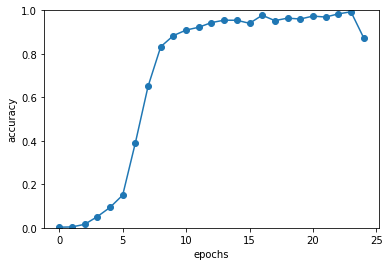

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from dataset import sequence
from common.optimizer import Adam
from common.trainer import Trainer
from common.util import eval_seq2seq
from seq2seq import Seq2seq
from peeky_seq2seq import PeekySeq2seq


# データセットの読み込み
(x_train, t_train), (x_test, t_test) = sequence.load_data('addition.txt')
char_to_id, id_to_char = sequence.get_vocab()

# Reverse input? =================================================
is_reverse = True  # True
if is_reverse:
    x_train, x_test = x_train[:, ::-1], x_test[:, ::-1]
# ================================================================

# ハイパーパラメータの設定
vocab_size = len(char_to_id)
wordvec_size = 16
hideen_size = 128
batch_size = 128
max_epoch = 25
max_grad = 5.0

# Normal or Peeky? ==============================================
# model = Seq2seq(vocab_size, wordvec_size, hideen_size)
model = PeekySeq2seq(vocab_size, wordvec_size, hideen_size)
# ================================================================
optimizer = Adam()
trainer = Trainer(model, optimizer)

acc_list = []
for epoch in range(max_epoch):
    trainer.fit(x_train, t_train, max_epoch=1,
                batch_size=batch_size, max_grad=max_grad)

    correct_num = 0
    for i in range(len(x_test)):
        question, correct = x_test[[i]], t_test[[i]]
        verbose = i < 10
        correct_num += eval_seq2seq(model, question, correct,
                                    id_to_char, verbose, is_reverse)

    acc = float(correct_num) / len(x_test)
    acc_list.append(acc)
    print('val acc %.3f%%' % (acc * 100))

# グラフの描画
x = np.arange(len(acc_list))
plt.plot(x, acc_list, marker='o')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.ylim(0, 1.0)
plt.show()